# Quantifying Data Distortion

Teng-Jui Lin

- Created: 2023-05-28
- Edited: 2024-06-18

In [1]:
from bar_constants import *
set_save_fig_rc()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Control Experiment Bar Graphs

### Control 1

(0.0, 60.0)

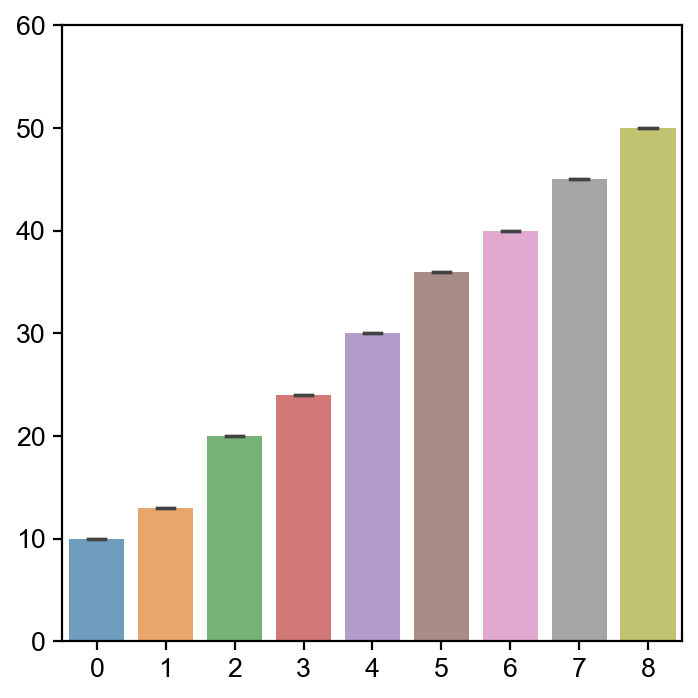

In [2]:
bar_df = pd.DataFrame(np.hstack([
    10 + np.zeros([SAMPLE_SIZE, 1]), 
    13 + np.zeros([SAMPLE_SIZE, 1]), 
    20 + np.zeros([SAMPLE_SIZE, 1]), 
    24 + np.zeros([SAMPLE_SIZE, 1]), 
    30 + np.zeros([SAMPLE_SIZE, 1]), 
    36 + np.zeros([SAMPLE_SIZE, 1]), 
    40 + np.zeros([SAMPLE_SIZE, 1]), 
    45 + np.zeros([SAMPLE_SIZE, 1]), 
    50 + np.zeros([SAMPLE_SIZE, 1]),
]))

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    bar_df,
    errorbar=BAR_ERRORBAR,
    capsize=BAR_CAPSIZE,
    linewidth=BAR_LINEWIDTH,
    edgecolor=BAR_EDGECOLOR,
    alpha=BAR_ALPHA,
    width=BAR_WIDTH,
    ax=ax,
)
# ax.set_box_aspect(2)
ax.set_ylim(0, 60)

In [3]:
def get_size_of_effect(series):
    # get permutations of all items as 2d array
    comb_arr = itertools.permutations(series, 2)
    comb_arr = np.array(list(comb_arr))
    # calculate size of effect for each permutation as series
    effect = np.diff(comb_arr).reshape(-1) / comb_arr[:, 0]
    effect = pd.Series(effect)
    return effect


def _get_lie_factor(viz_series, val_series):
    return get_size_of_effect(viz_series) / get_size_of_effect(val_series)


def get_lie_factor(viz_series, val_series):
    return viz_series / val_series

In [4]:
control1_val_series = pd.Series(np.array([10, 13, 20, 24, 30, 36, 40, 45, 50]))
control1_val_series.name = 'Data Value'
control1_val_series

0    10
1    13
2    20
3    24
4    30
5    36
6    40
7    45
8    50
Name: Data Value, dtype: int64

In [5]:
control1_viz_df = pd.read_csv(os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'control', 'control_fig1.csv'), header=None, index_col=0)
control1_viz_df = control1_viz_df.reset_index(drop=True)
control1_viz_series = control1_viz_df.iloc[:, 0]
control1_viz_series.name = 'Visual Value'
control1_viz_series

0     9.868491
1    12.887194
2    19.898377
3    23.890856
4    29.928263
5    35.868292
6    39.860771
7    44.924403
8    49.890657
Name: Visual Value, dtype: float64

In [6]:
lie_factor_df = _get_lie_factor(control1_viz_series, control1_val_series)

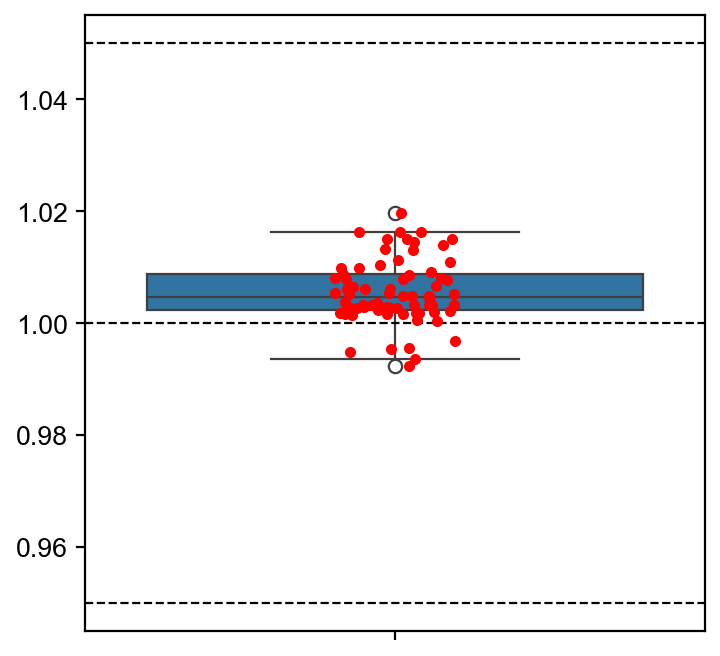

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    lie_factor_df,
    ax=ax,
    log_scale=False,
)
sns.stripplot(
    lie_factor_df,
    ax=ax,
    color='r',
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

(-5.0, 1.5)

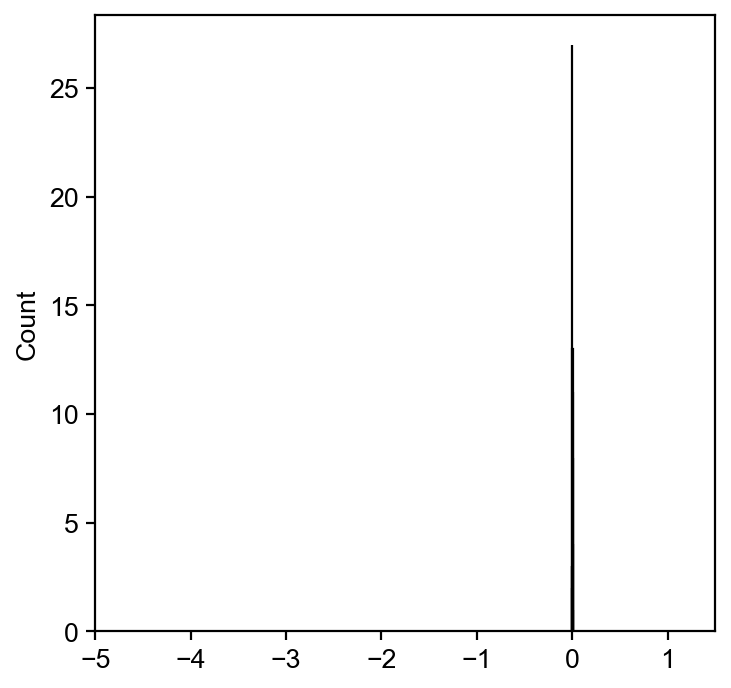

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(
    np.log10(lie_factor_df),
    ax=ax,
)
ax.set_xlim(-5, 1.5)

### Control 2

(0.0, 140.0)

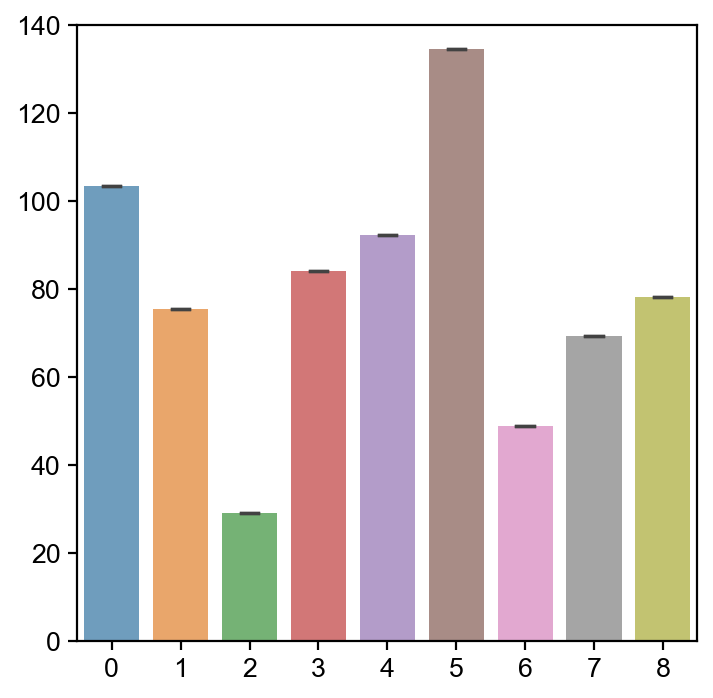

In [9]:
bar_df = pd.DataFrame(np.hstack([
    103.4 + np.zeros([SAMPLE_SIZE, 1]), 
    75.6 + np.zeros([SAMPLE_SIZE, 1]), 
    29.2 + np.zeros([SAMPLE_SIZE, 1]), 
    84.1 + np.zeros([SAMPLE_SIZE, 1]), 
    92.3 + np.zeros([SAMPLE_SIZE, 1]), 
    134.6 + np.zeros([SAMPLE_SIZE, 1]), 
    48.9 + np.zeros([SAMPLE_SIZE, 1]), 
    69.3 + np.zeros([SAMPLE_SIZE, 1]), 
    78.3 + np.zeros([SAMPLE_SIZE, 1]),
]))

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    bar_df,
    errorbar=BAR_ERRORBAR,
    capsize=BAR_CAPSIZE,
    linewidth=BAR_LINEWIDTH,
    edgecolor=BAR_EDGECOLOR,
    alpha=BAR_ALPHA,
    width=BAR_WIDTH,
    ax=ax,
)
# ax.set_box_aspect(2)
ax.set_ylim(0, 140)

In [10]:
control2_val_series = pd.Series(np.array([103.4, 75.6, 29.2, 84.1, 92.3, 134.6, 48.9, 69.3, 78.3]))
control2_val_series.name = 'Data Value'
control2_val_series

0    103.4
1     75.6
2     29.2
3     84.1
4     92.3
5    134.6
6     48.9
7     69.3
8     78.3
Name: Data Value, dtype: float64

In [11]:
control2_viz_df = pd.read_csv(os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'control', 'control_fig2.csv'), header=None, index_col=0)
control2_viz_df = control2_viz_df.reset_index(drop=True)
control2_viz_series = control2_viz_df.iloc[:, 0]
control2_viz_series.name = 'Visual Value'
control2_viz_series

0    103.233107
1     75.285755
2     28.934049
3     83.919896
4     92.099609
5    134.361458
6     48.701688
7     68.923756
8     78.012326
Name: Visual Value, dtype: float64

In [12]:
lie_factor_df = _get_lie_factor(control2_viz_series, control2_val_series)

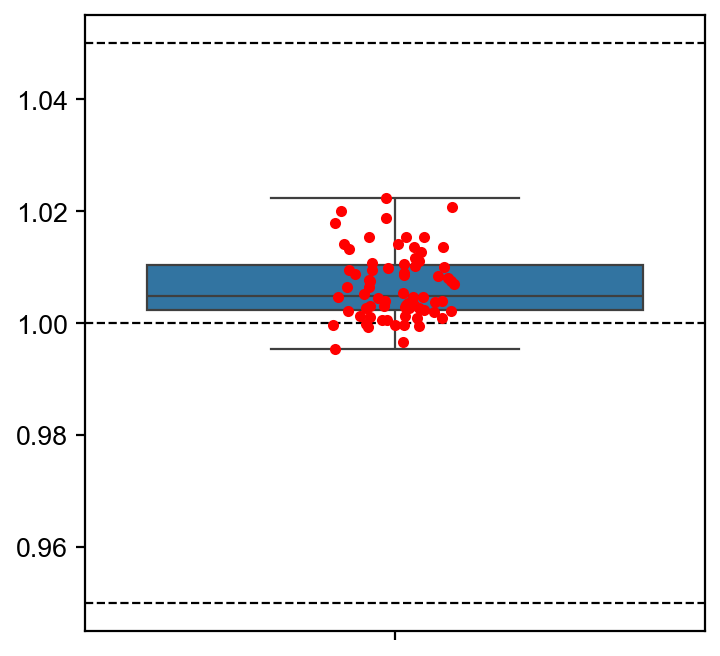

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    lie_factor_df,
    ax=ax,
    log_scale=False,
)
sns.stripplot(
    lie_factor_df,
    ax=ax,
    color='r',
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

(-5.0, 1.5)

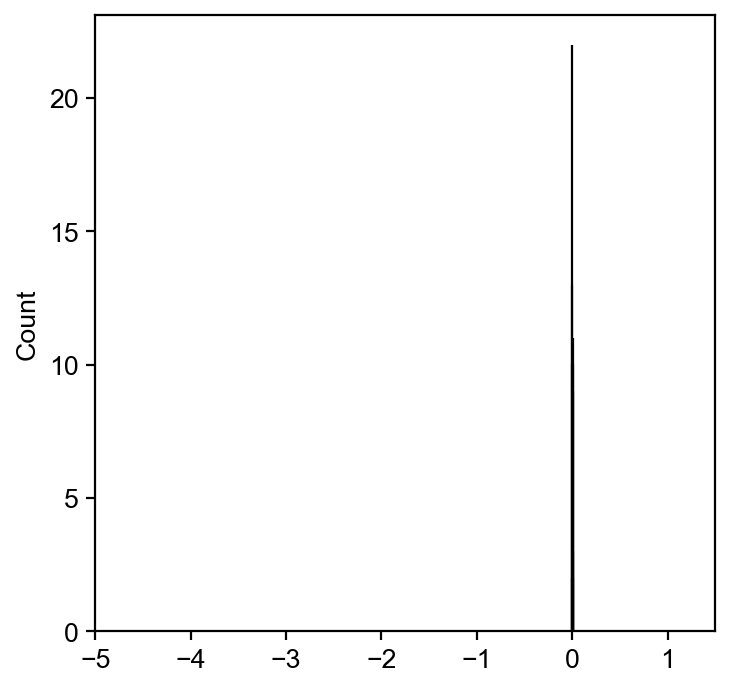

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(
    np.log10(lie_factor_df),
    ax=ax,
)
ax.set_xlim(-5, 1.5)

## Nature Biomedical Engineering

In [15]:
cv = lambda series: series.std() / series.mean()

## Graph annotations

In [16]:
journals = [
    'acs_nano',
    'bioeng_transl_med',
    'cell',
    'nat_biomed_eng',
    'nat_biotechnol',
    'nat_cancer',
    'nat_cell_biol',
    'nat_nanotechnol',
    'nat_neurosci',
    'nat_plants',
    'nature',
    'sci_immunol',
    'sci_signal',
    'sci_transl_med',
    'science',
]
mistakes = [ZERO_SUBDIR, LOG_SUBDIR]
bar_annot_df_list = []
for journal in journals:
    mistake_bar_annot_df_list = []
    for mistake in mistakes:
        # get filepaths of graph quantity annotation
        annot_df_ = pd.read_excel(os.path.join(f'data/misused_bar_graph_figures/{journal}/{mistake}', 'annotation.xlsx'), index_col=0)
        mistake_bar_annot_df_list.append(annot_df_)
    # construct journal-level annotation df
    journal_annot_df = pd.concat(mistake_bar_annot_df_list)
    bar_annot_df_list.append(journal_annot_df)
    
# construct overall df
bar_annot_df = pd.concat(bar_annot_df_list)
bar_annot_df

,DOI,Mistake,Fig ID,Journal,Quantity,Absolute/Relative,Measurement Type,Physical quantity I,Physical quantity II,Log transformation
Fig Index,,,,,,,,,,
10.1021:acsnano.2c07293_zero_fig1,10.1021:acsnano.2c07293,zero,1,acs_nano,Temperature (°C),Relative,Measured value,Temperature,Temperature,No
10.1021:acsnano.2c07436_zero_fig1,10.1021:acsnano.2c07436,zero,1,acs_nano,Hydroxy radicals scavenging (%),Relative,Percentage,Percentage,Percentage,No
10.1021:acsnano.2c07439_zero_fig1,10.1021:acsnano.2c07439,zero,1,acs_nano,Intracellular MFI (a.u.),Relative,Calculated value,Relative luminescence,Fluorescence,No
10.1021:acsnano.2c08153_zero_fig1,10.1021:acsnano.2c08153,zero,1,acs_nano,Wavelength shift (nm),Absolute,Measured value,Length,Length,No
10.1021:acsnano.2c08190_zero_fig1,10.1021:acsnano.2c08190,zero,1,acs_nano,Percentage of DCF fluorescence (%),Relative,Percentage,Percentage,Percentage,No
...,...,...,...,...,...,...,...,...,...,...
10.1126:science.adi2246_log_fig2,10.1126:science.adi2246,log,2,science,Relative fold change cs WT (normalized by GAPDH),Relative,Ratio,Ratio,Ratio,No
10.1126:science.adi2246_log_fig3,10.1126:science.adi2246,log,3,science,Relative gene expression (vs GAPDH),Relative,Ratio,Ratio,Ratio,No
10.1126:science.adi8885_log_fig1,10.1126:science.adi8885,log,1,science,KO/WT (log10),Relative,Ratio,Ratio,Ratio,10


In [17]:
bar_annot_df[bar_annot_df['Quantity'].str.contains('CFU') & ~bar_annot_df['Physical quantity I'].str.contains('Titer')]

,DOI,Mistake,Fig ID,Journal,Quantity,Absolute/Relative,Measurement Type,Physical quantity I,Physical quantity II,Log transformation
Fig Index,,,,,,,,,,
10.1038:s41586-023-06597-1_log_fig1,10.1038:s41586-023-06597-1,log,1,nature,Normalized CFU,Relative,Ratio,Ratio,Ratio,No
10.1038:s41586-023-06597-1_log_fig8,10.1038:s41586-023-06597-1,log,8,nature,Normalized CFU,Relative,Ratio,Ratio,Ratio,No
10.1038:s41586-023-06597-1_log_fig9,10.1038:s41586-023-06597-1,log,9,nature,Normalized CFU,Relative,Ratio,Ratio,Ratio,No
10.1126:scisignal.abj8194_log_fig1,10.1126:scisignal.abj8194,log,1,sci_signal,RFU (normalized to CFU),Relative,Calculated value,Relative luminescence,Fluorescence,No


In [18]:
, 'Angle', 'Area', 'Energy', ,'', '', 'Rate', 'Volume'
bar_annot_df[bar_annot_df['Physical quantity I'].isin([
    'Colony count'
       
])]

,DOI,Mistake,Fig ID,Journal,Quantity,Absolute/Relative,Measurement Type,Physical quantity I,Physical quantity II,Log transformation
Fig Index,,,,,,,,,,


In [19]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count().index

Index(['Bioluminescence', 'Concentration', 'Constant', 'Count', 'Fluorescence',
       'Length', 'Mass', 'Others', 'Percentage', 'Prediction metric', 'Ratio',
       'Statistics', 'Temperature', 'Time'],
      dtype='object', name='Physical quantity II')

In [20]:
bar_annot_df[bar_annot_df['Physical quantity II'] == 'Concentration'].groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count()

,DOI,Mistake,Fig ID
Physical quantity I,,,
Characteristic concentration,26,26,26
Concentration,70,70,70
Cytokine concentration,35,35,35
Titer,82,82,82


In [21]:
for quant_idx in bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count().index:
    print(bar_annot_df[bar_annot_df['Physical quantity II'] == quant_idx].groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count())

                       DOI  Mistake  Fig ID
Physical quantity I                        
Radiance                 3        3       3
Radiant efficiency       2        2       2
Radiant flux             8        8       8
Relative luminescence   18       18      18
                              DOI  Mistake  Fig ID
Physical quantity I                               
Characteristic concentration   26       26      26
Concentration                  70       70      70
Cytokine concentration         35       35      35
Titer                          82       82      82
                     DOI  Mistake  Fig ID
Physical quantity I                      
Constant              24       24      24
Index                 25       25      25
                     DOI  Mistake  Fig ID
Physical quantity I                      
Cell count            49       49      49
Count                 95       95      95
                          DOI  Mistake  Fig ID
Physical quantity I                           


In [22]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index()

,DOI,Mistake,Physical quantity I,Fig ID
0,10.1002:btm2.10487,log,Constant,2
1,10.1002:btm2.10499,zero,Concentration,1
2,10.1002:btm2.10499,zero,Cytokine concentration,5
3,10.1002:btm2.10504,zero,Titer,1
4,10.1002:btm2.10505,zero,Titer,2
...,...,...,...,...
1241,10.1126:scitranslmed.adh4529,log,Count,1
1242,10.1126:scitranslmed.adh7668,zero,Count,1
1243,10.1126:scitranslmed.adi1617,log,Radiance,1
1244,10.1126:scitranslmed.adi7244,zero,Cell percentage,3


In [23]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count()

,DOI,Mistake,Fig ID
Physical quantity I,,,
AUC,12,12,12
Accuracy,11,11,11
Angle,5,5,5
Area,9,9,9
Cell count,49,49,49
Cell percentage,53,53,53
Cell viability,19,19,19
Characteristic concentration,26,26,26
Colon length,9,9,9


<Axes: xlabel='Absolute/Relative,Mistake'>

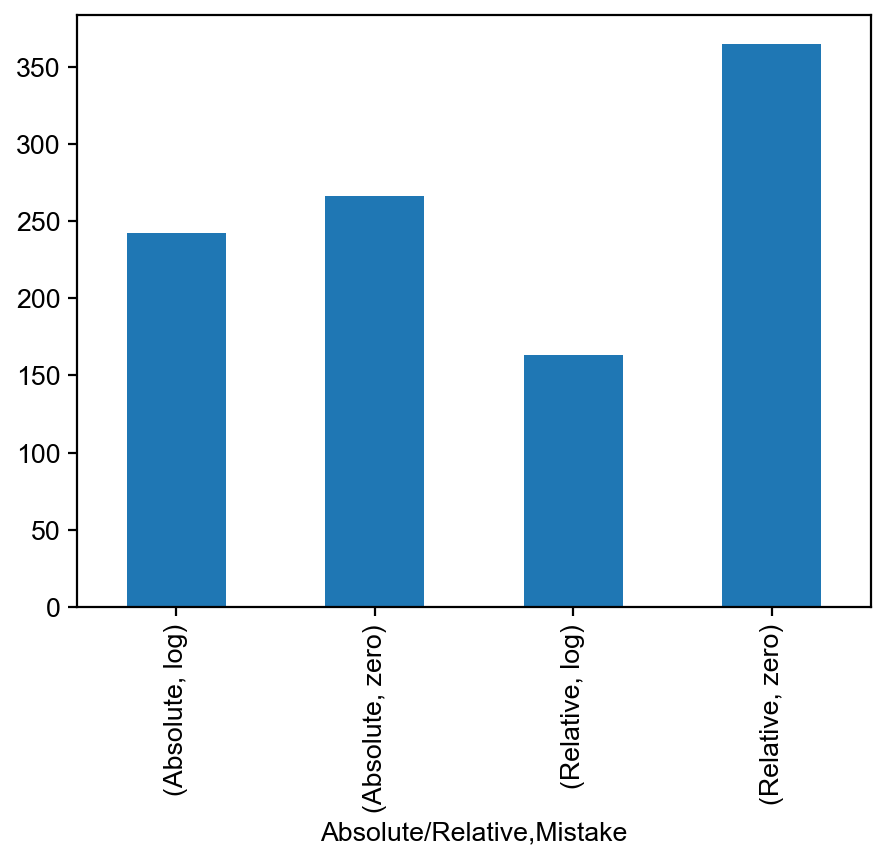

In [24]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index().groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].plot(kind='bar')

<Axes: xlabel='Measurement Type,Mistake'>

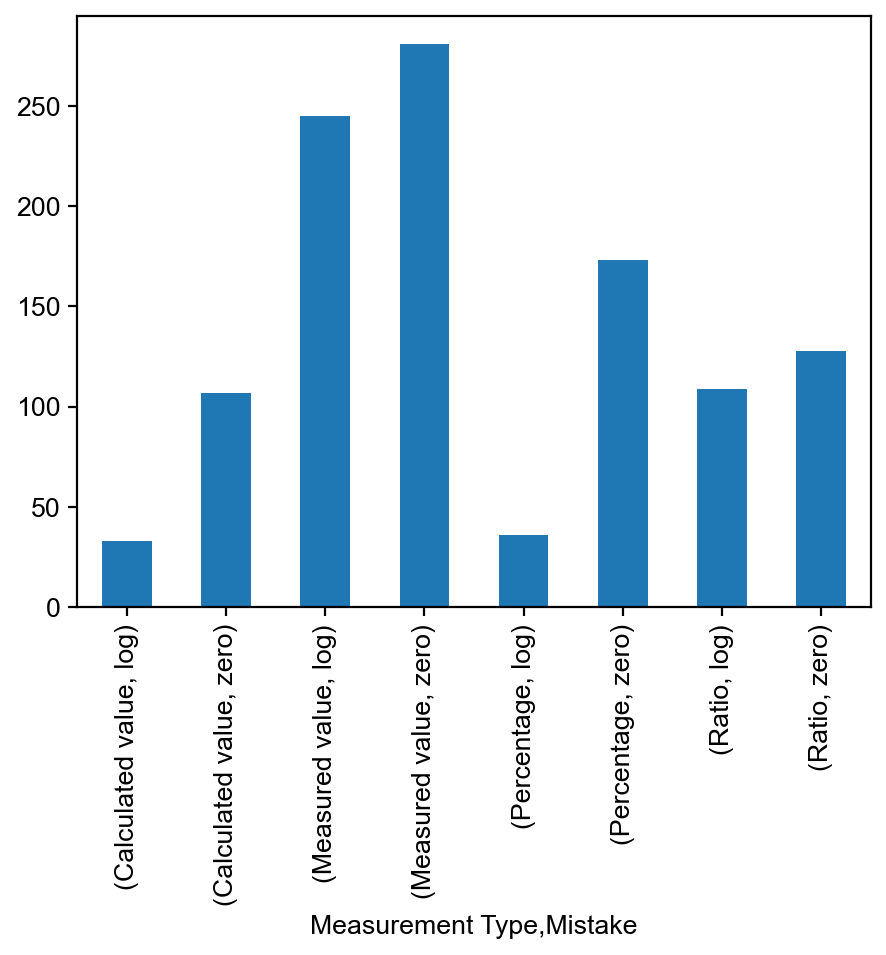

In [25]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Measurement Type']).count().iloc[:, 0].reset_index().groupby(['Measurement Type', 'Mistake']).count().iloc[:, 0].plot(kind='bar')

<Axes: xlabel='Physical quantity II,Mistake'>

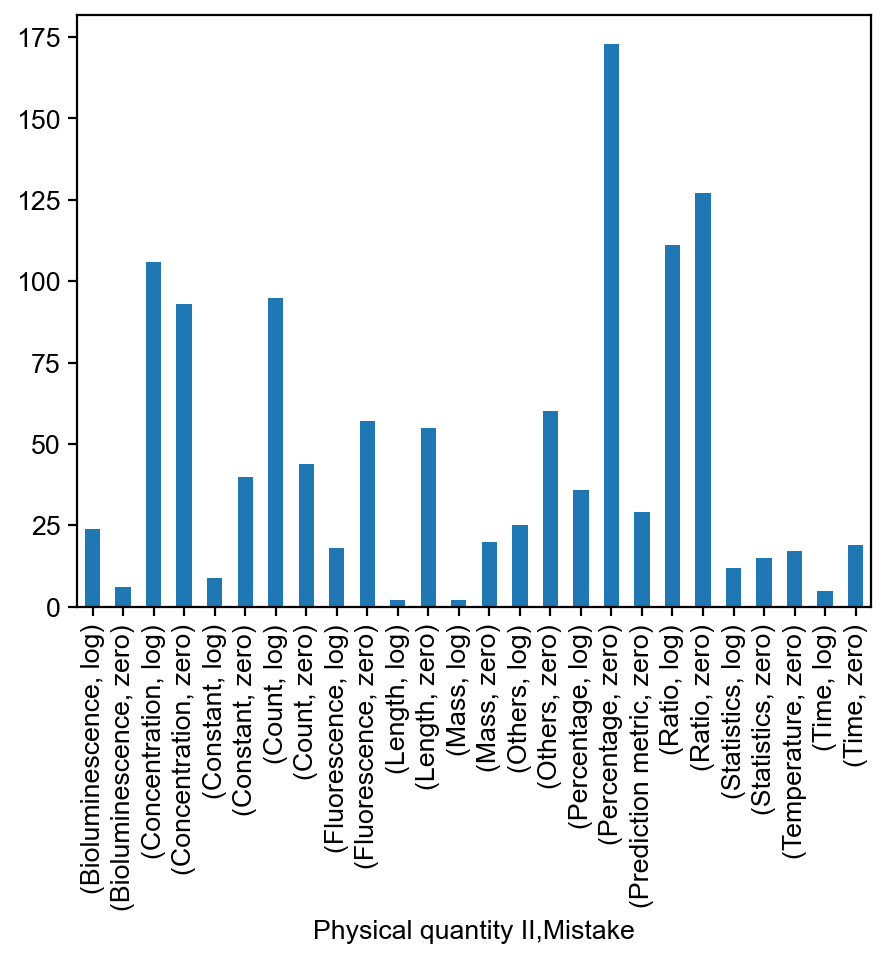

In [26]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II', 'Mistake']).count().iloc[:, 0].plot(kind='bar')

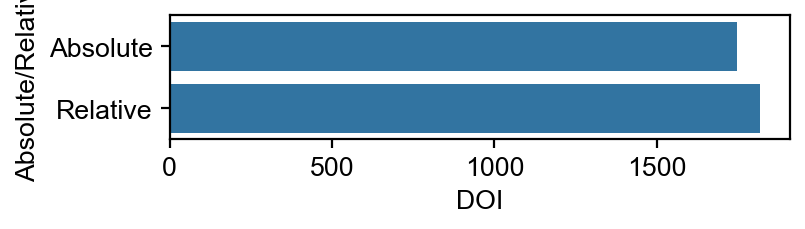

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    data=bar_annot_df.groupby('Absolute/Relative').count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby('Absolute/Relative').count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(0.2)

In [28]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count().sum()

DOI        1200
Mistake    1200
Fig ID     1200
dtype: int64

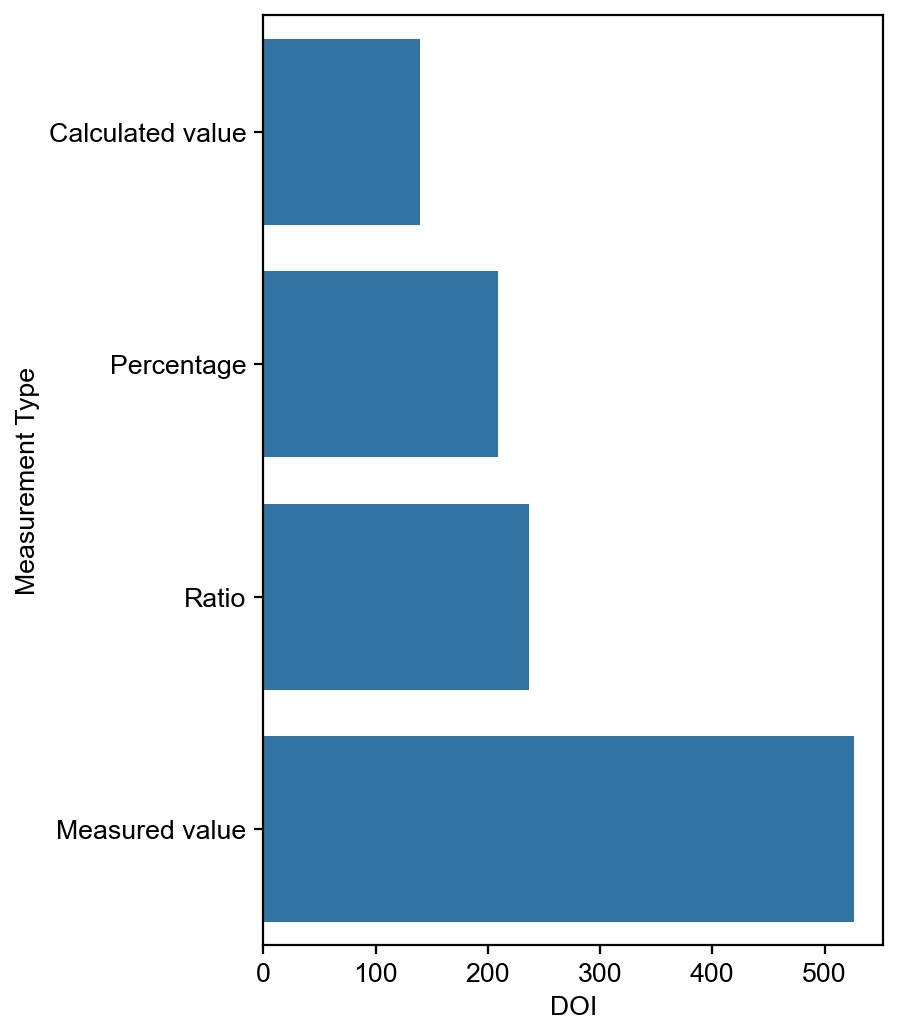

In [29]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data=bar_annot_df.groupby(['DOI', 'Mistake', 'Measurement Type']).count().iloc[:, 0].reset_index().groupby(['Measurement Type']).count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby(['DOI', 'Mistake', 'Measurement Type']).count().iloc[:, 0].reset_index().groupby(['Measurement Type']).count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(1.5)

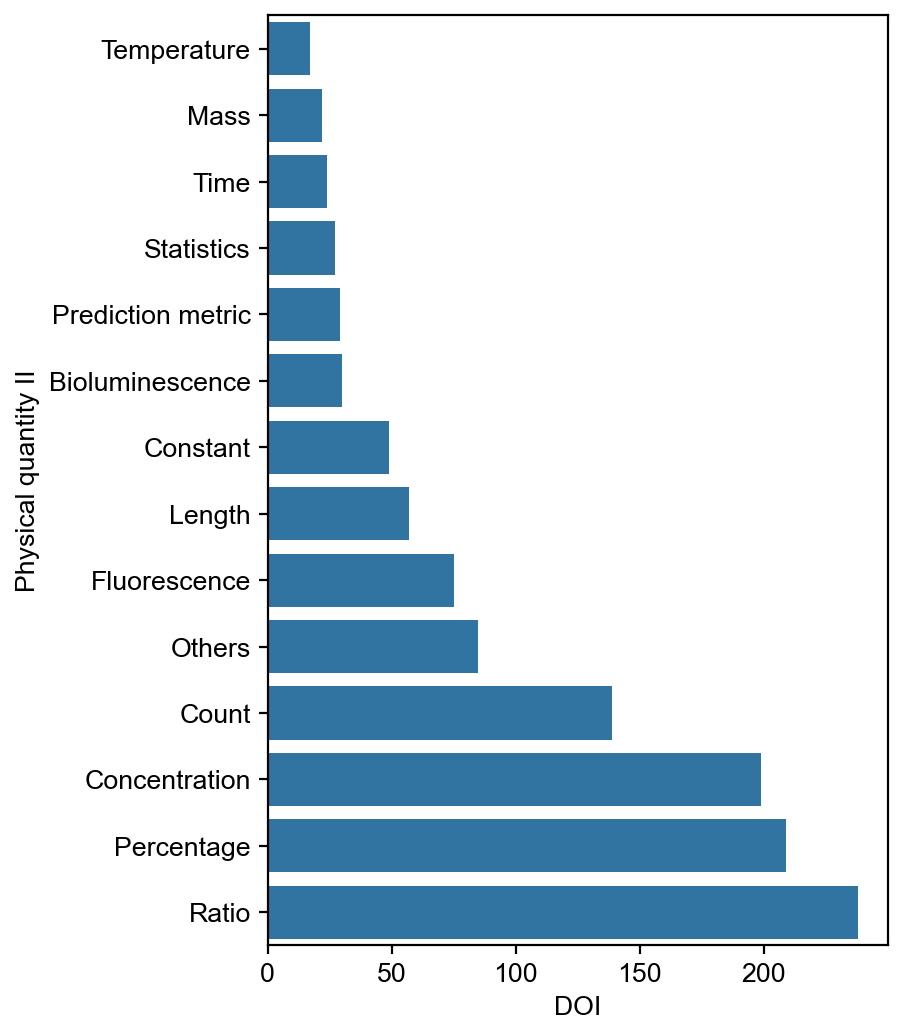

In [30]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data=bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(1.5)

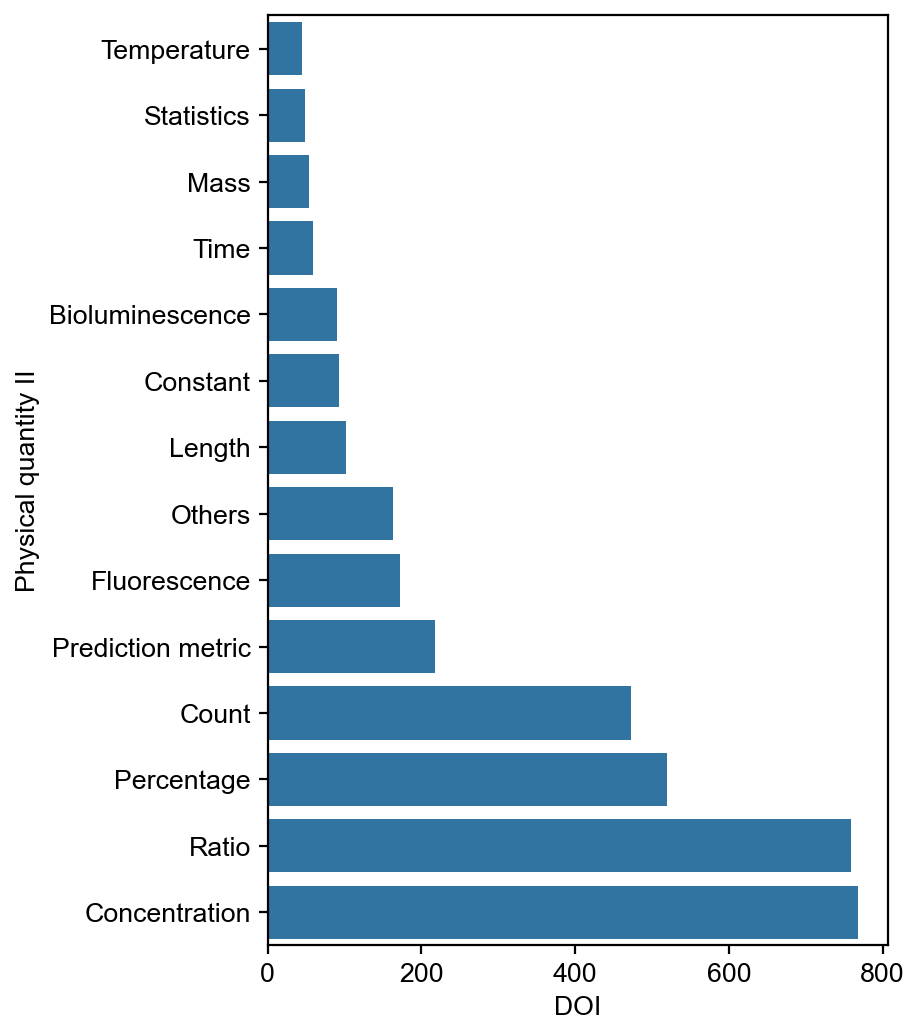

In [31]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data=bar_annot_df.groupby('Physical quantity II').count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby('Physical quantity II').count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(1.5)

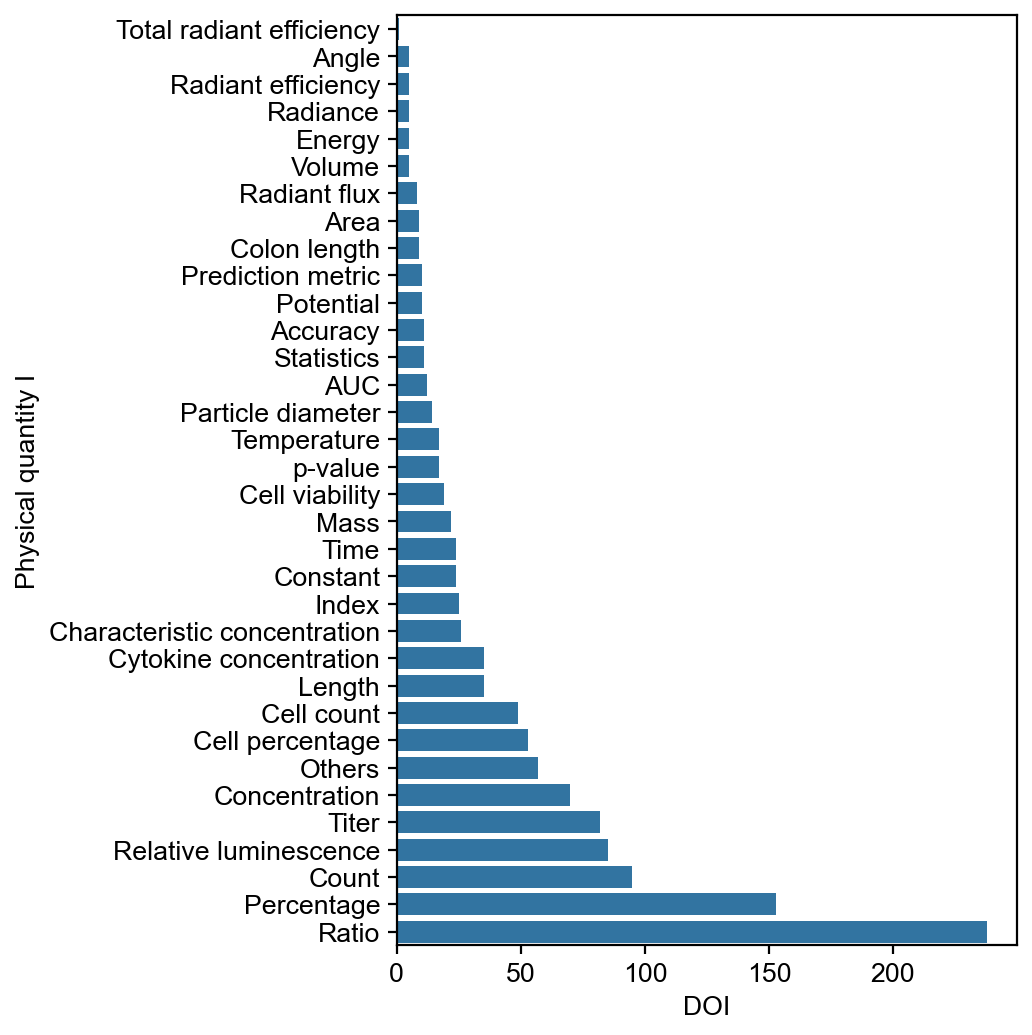

In [32]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data=bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(1.5)

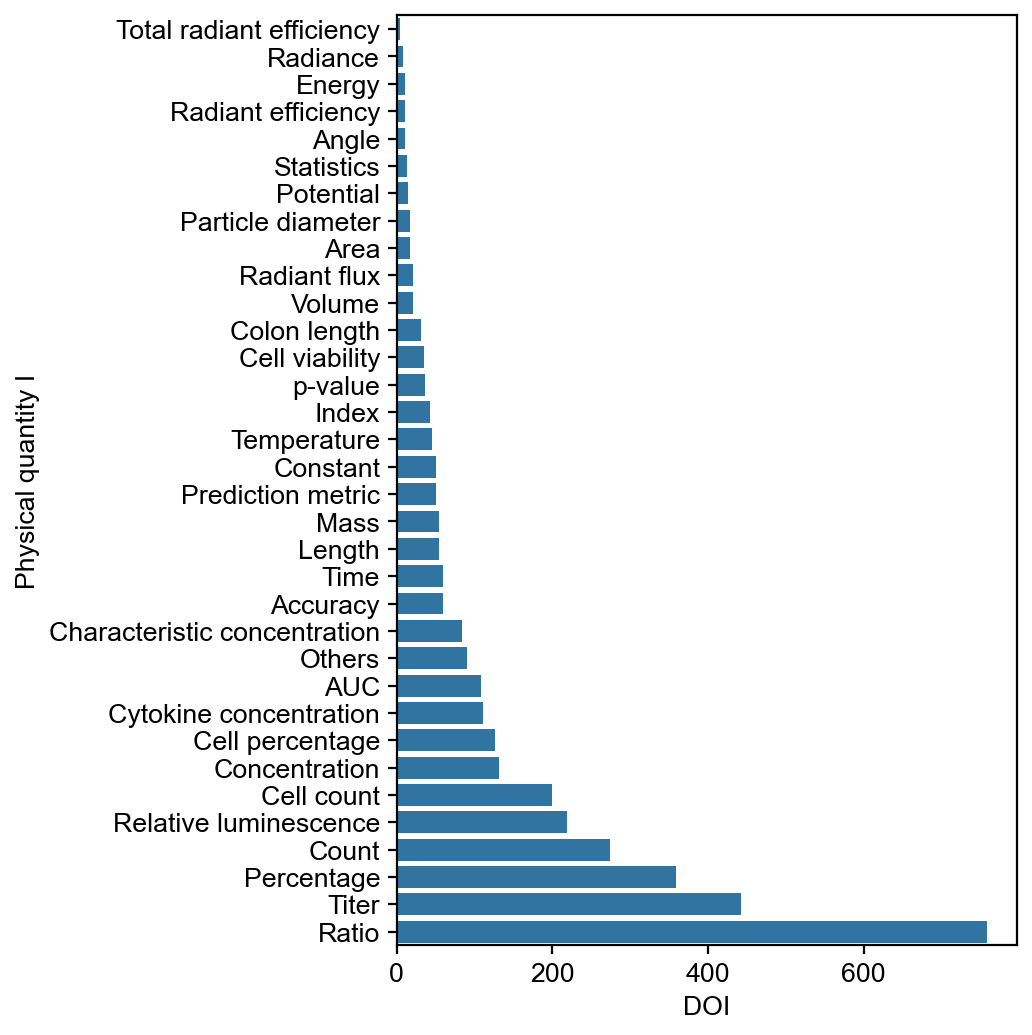

In [33]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data=bar_annot_df.groupby('Physical quantity I').count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby('Physical quantity I').count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(1.5)

In [34]:
bar_annot_df[bar_annot_df['Physical quantity II'].isin(['Length'])].groupby('Physical quantity I').count()

,DOI,Mistake,Fig ID,Journal,Quantity,Absolute/Relative,Measurement Type,Physical quantity II,Log transformation
Physical quantity I,,,,,,,,,
Colon length,31,31,31,31,31,31,31,31,31
Length,54,54,54,54,54,54,54,54,54
Particle diameter,17,17,17,17,17,17,17,17,17


In [35]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count()

,DOI,Mistake,Fig ID
Physical quantity II,,,
Bioluminescence,30,30,30
Concentration,199,199,199
Constant,49,49,49
Count,139,139,139
Fluorescence,75,75,75
Length,57,57,57
Mass,22,22,22
Others,85,85,85
Percentage,209,209,209


In [36]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index().groupby(['Absolute/Relative']).count()

,DOI,Mistake,Fig ID
Absolute/Relative,,,
Absolute,508,508,508
Relative,528,528,528


## Bar-level data

In [37]:
X_LABEL = 'True Value'
Y_LABEL = 'Visualized Value'
ALPHA_MARK_LABEL = 'Mark Proportionality Constant'
ALPHA_DIFF_LABEL = 'Difference Proportionality Constant'

In [38]:
journals = [
    'acs_nano',
    'bioeng_transl_med',
    'cell',
    'nat_biomed_eng',
    'nat_biotechnol',
    'nat_cancer',
    'nat_cell_biol',
    'nat_nanotechnol',
    'nat_neurosci',
    'nat_plants',
    'nature',
    'sci_immunol',
    'sci_signal',
    'sci_transl_med',
    'science',
]
mistakes = [ZERO_SUBDIR, LOG_SUBDIR]
value_labels = [VAL_LABEL, VIZ_LABEL]
value_label_labels = [X_LABEL, Y_LABEL]

zero_bar_df_list = []
log_bar_df_list = []
for journal in journals:
    mistake_zero_bar_df_list = []
    mistake_log_bar_df_list = []
    for mistake in mistakes:
        # EXTRACT TRUE AND VISUALIZED VALUES
        for j, value_label in enumerate(value_labels):
            # get filepaths of digitized values in csv
            filepath = os.path.join(DATA_DIR, MISUSED_BAR_DIR, journal, mistake)
            filenames = os.listdir(filepath)
            filenames = pd.Series(filenames)
            filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(value_label)]
            filenames = filenames.reset_index(drop=True)
            fignames = filenames.str.slice(stop=-8)
            fig_fullids = fignames.str.replace('fig', '')
            filepaths = filepath + os.sep + filenames
            # read individual csv
            raw_df_dict = {}
            for i, filepath in enumerate(filepaths):
                bar_df_ = pd.read_csv(filepath, header=None, index_col=0)
                bar_df_ = bar_df_.reset_index(drop=True)
                # bar_df_.columns = [value_label]
                bar_df_.columns = [value_label_labels[j]]
                # # add metadata
                # doi, _, figid = fig_fullids[i].split('_')
                # bar_df_['Journal'] = journal
                # bar_df_['DOI'] = doi
                # bar_df_['Mistake'] = mistake
                # bar_df_['Fig ID'] = figid
                raw_df_dict[fignames[i]] = bar_df_
            
            # construct mistake-level df
            mistake_level_bar_df = pd.concat(raw_df_dict)
            if mistake == ZERO_SUBDIR:
                mistake_zero_bar_df_list.append(mistake_level_bar_df)
            elif mistake == LOG_SUBDIR:
                mistake_log_bar_df_list.append(mistake_level_bar_df)
            else:
                raise ValueError

    # construct journal-level bar df
    # zero
    journal_zero_bar_df = mistake_zero_bar_df_list[0].copy()
    journal_zero_bar_df[Y_LABEL] = mistake_zero_bar_df_list[1][Y_LABEL]
    journal_zero_bar_df[ALPHA_MARK_LABEL] = journal_zero_bar_df[Y_LABEL] / journal_zero_bar_df[X_LABEL]
    zero_bar_df_list.append(journal_zero_bar_df)
    # log
    journal_log_bar_df = mistake_log_bar_df_list[0].copy()
    journal_log_bar_df[Y_LABEL] = mistake_log_bar_df_list[1][Y_LABEL]
    journal_log_bar_df[ALPHA_MARK_LABEL] = journal_log_bar_df[Y_LABEL] / journal_log_bar_df[X_LABEL]
    log_bar_df_list.append(journal_log_bar_df)

# construct overall df
zero_bar_df = pd.concat(zero_bar_df_list)
log_bar_df = pd.concat(log_bar_df_list)
bar_df = pd.concat([zero_bar_df, log_bar_df])
bar_df

True Value  Visualized Value  \
10.1021:acsnano.3c07517_zero_fig2 0    1.000787          0.200787   
                                  1    1.469291          0.669291   
                                  2    1.264567          0.464567   
10.1021:acsnano.2c10352_zero_fig2 0   20.389610          0.259740   
                                  1   21.255411          0.281385   
...                                         ...               ...   
10.1126:science.ade3483_log_fig1  0  593.139572          0.924386   
                                  1  507.112096          0.901701   
                                  2    7.768894          0.296786   
                                  3    6.061899          0.260870   
                                  4    4.489251          0.217391   

                                     Mark Proportionality Constant  
10.1021:acsnano.3c07517_zero_fig2 0                       0.200629  
                                  1                       0.455520  
                                  2                       0.367372  
10.1021:acsnano.2c10352_zero_fig2 0                       0.012739  
                                  1                       0.013238  
...                                                            ...  
10.1126:science.ade3483_log_fig1  0                       0.001558  
                                  1                       0.001778  
                                  2                       0.038202  
                                  3                       0.043034  
                                  4                       0.048425  

[17837 rows x 3 columns]

## Pairwise permutation-level metric

In [39]:
def perm_rel_change(df, label):
    perm_arr = itertools.permutations(df[label].reset_index(drop=True), 2)
    perm_arr = np.array(list(perm_arr))
    rel_change = (perm_arr[:, 1] - perm_arr[:, 0]) / perm_arr[:, 0]
    rel_change = pd.Series(rel_change)
    return pd.DataFrame(perm_arr), rel_change

In [40]:
def perm_rel_change(df, label):
    perm_arr = itertools.permutations(df[label].reset_index(drop=True), 2)
    perm_arr = pd.DataFrame(np.array(list(perm_arr)))
    return perm_arr

In [41]:
L_df_list = []
fig_id = np.unique(bar_df.index.get_level_values(0))
for i in range(len(fig_id)):
    df = bar_df[bar_df.index.get_level_values(0) == fig_id[i]]
    
    # generate permutations and their respective x, y values
    L_df_ = pd.concat(
        [
            perm_rel_change(df, X_LABEL), 
            perm_rel_change(df, Y_LABEL),
        ], 
        axis=1
    )
    L_df_.columns = ['x_1', 'x_2', 'y_1', 'y_2']

    # store bar id
    L_df_[['Bar 1 ID', 'Bar 2 ID']] = perm_rel_change(bar_df[bar_df.index.get_level_values(0) == fig_id[i]].reset_index(), 'level_1')
    
    # compute lie factor of relative change
    L_df_['E_x_12'] = (L_df_['x_1'] - L_df_['x_2']) / L_df_['x_2']
    L_df_['E_y_12'] = (L_df_['y_1'] - L_df_['y_2']) / L_df_['y_2']
    L_df_['L_12'] = L_df_['E_y_12'] / L_df_['E_x_12']
    L_df_['log L_12'] = np.log10(L_df_['L_12'])

    # compute GDI
    L_df_['GDI_12'] = 100 * (L_df_['L_12'] - 1)

    # compute lie factor of fold change
    L_df_['F_12'] = (L_df_['x_1'] / L_df_['x_2']) / (L_df_['y_1'] / L_df_['y_2'])
    L_df_['log F_12'] = np.log10(L_df_['F_12'])

    # compute RGD
    L_df_['RGD_12'] = L_df_['L_12'] - 1

    # add meta data
    # L_df_['Journal'] = df['Journal'][0]
    # L_df_['DOI'] = df['DOI'][0]
    # L_df_['Mistake'] = df['Mistake'][0]
    # L_df_['Fig ID'] = df['Fig ID'][0]
    L_df_['Fig Index'] = df.index.get_level_values(0)[0]
    
    # add quantity annotation
    # L_df_['Quantity'] = df['Quantity'][0]
    # L_df_['Absolute/Relative'] = df['Absolute/Relative'][0]
    # L_df_['Measurement Type'] = df['Measurement Type'][0]
    # L_df_['Physical quantity I'] = df['Physical quantity I'][0]
    # L_df_['Physical quantity II'] = df['Physical quantity II'][0]
    # L_df_['Log transformation'] = df['Log transformation'][0]
    
    L_df_list.append(L_df_)
L_df = pd.concat(L_df_list, ignore_index=True)
L_df = L_df.set_index('Fig Index')
# L_annotation_df = L_df[['Quantity', 'Absolute/Relative', 'Measurement Type', 'Physical quantity I', 'Physical quantity II', 'Log transformation']].copy()
# L_df = L_df.drop(['Quantity', 'Absolute/Relative', 'Measurement Type', 'Physical quantity I', 'Physical quantity II', 'Log transformation'], axis=1)
L_df

,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12
Fig Index,,,,,,,,,,,,,,
10.1002:btm2.10487_log_fig1,0.941271,17.800504,0.352212,0.803540,0,1,-0.947121,-0.561674,0.593033,-0.226921,-40.696707,0.120638,-0.918515,-0.406967
10.1002:btm2.10487_log_fig1,0.941271,0.297195,0.352212,0.175221,0,2,2.167186,1.010101,0.466089,-0.331531,-53.391128,1.575635,0.197456,-0.533911
10.1002:btm2.10487_log_fig1,0.941271,3.977009,0.352212,0.573451,0,3,-0.763322,-0.385802,0.505426,-0.296343,-49.457437,0.385345,-0.414150,-0.494574
10.1002:btm2.10487_log_fig1,17.800504,0.941271,0.803540,0.352212,1,0,17.911138,1.281407,0.071542,-1.145436,-92.845753,8.289243,0.918515,-0.928458
10.1002:btm2.10487_log_fig1,17.800504,0.297195,0.803540,0.175221,1,2,58.895093,3.585859,0.060886,-1.215486,-93.911448,13.060824,1.115971,-0.939114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1126:scitranslmed.adi9867_log_fig2,1331.015174,786.004146,0.795732,0.742378,2,1,0.693395,0.071869,0.103647,-0.984441,-89.635255,1.579853,0.198617,-0.896353
10.1126:scitranslmed.adi9867_log_fig2,1331.015174,437.041699,0.795732,0.682927,2,3,2.045511,0.165179,0.080752,-1.092848,-91.924825,2.613772,0.417268,-0.919248
10.1126:scitranslmed.adi9867_log_fig2,437.041699,2504.337233,0.682927,0.859756,3,0,-0.825486,-0.205674,0.249155,-0.603531,-75.084527,0.219701,-0.658169,-0.750845


### Only median of each plot

- Bias in different number of bars
  - If include every point in each plot, graphs with more plots will have an advantage by pairwise permutation (n(n-1)).
  - Taking median of each plot?
- Bias in different number of plots for the same type of quantity
  - If include every similar plot, similar deviation is exaggerated
  - Taking median among all plots?
  - Do we have enough data point for journal level analysis?
- Put raw biased plots in supplemental information

In [42]:
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Mistake']])
plot_df

,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12,Absolute/Relative,Mistake
Fig Index,,,,,,,,,,,,,,,,
10.1002:btm2.10487_log_fig1,2.459140,2.459140,0.462832,0.462832,1.5,1.5,0.741462,0.057445,0.417407,-0.382415,-58.259341,1.105150,0.000000e+00,-0.582593,Absolute,log
10.1002:btm2.10487_log_fig2,6.461362,6.461362,0.448692,0.448692,1.5,1.5,0.859204,0.077444,0.427339,-0.374663,-57.266116,1.099787,0.000000e+00,-0.572661,Absolute,log
10.1002:btm2.10499_zero_fig1,23.125241,23.125241,0.366089,0.366089,3.5,3.5,0.000306,0.003109,4.692459,0.664729,369.245939,1.001392,3.295975e-17,3.692459,Absolute,zero
10.1002:btm2.10499_zero_fig2,17.704626,17.704626,0.423488,0.423488,3.0,3.0,0.000014,0.000021,1.393557,0.144125,39.355742,1.000001,1.114018e-17,0.393557,Absolute,zero
10.1002:btm2.10499_zero_fig3,13.212996,13.212996,0.328520,0.328520,3.0,3.0,0.000007,0.000020,1.608791,0.206500,60.879121,1.000003,-2.016616e-17,0.608791,Absolute,zero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1126:scitranslmed.adi7244_zero_fig1,48.135048,48.135048,0.604502,0.604502,0.5,0.5,0.013930,0.102449,2.738993,0.433283,173.899336,1.040072,-6.938894e-18,1.738993,Relative,zero
10.1126:scitranslmed.adi7244_zero_fig2,88.396694,88.396694,0.439669,0.439669,0.5,0.5,0.001313,0.722065,27.002885,1.370101,2600.288534,1.652451,5.551115e-17,26.002885,Relative,zero
10.1126:scitranslmed.adi7244_zero_fig3,68.875639,68.875639,0.471891,0.471891,0.5,0.5,0.028594,0.462064,4.260902,0.604216,326.090183,1.246988,-5.551115e-17,3.260902,Relative,zero


In [43]:
import scipy
# absolute/relative
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
# mistake: zero/log
log_cond = (plot_df['Mistake'] == 'log')
zero_cond = (plot_df['Mistake'] == 'zero')

In [44]:
scipy.stats.mannwhitneyu(
    plot_df.loc[abs_cond & log_cond, 'log L_12'].dropna(),
    plot_df.loc[rel_cond & log_cond, 'log L_12'].dropna(),
)

MannwhitneyuResult(statistic=73391.0, pvalue=9.312616771552386e-26)

In [45]:
scipy.stats.mannwhitneyu(
    plot_df.loc[abs_cond & zero_cond, 'log L_12'].dropna(),
    plot_df.loc[rel_cond & zero_cond, 'log L_12'].dropna(),
)

MannwhitneyuResult(statistic=406508.0, pvalue=0.0009303740641567606)

In [46]:
scipy.stats.mannwhitneyu(
    plot_df.loc[abs_cond & log_cond, 'log F_12'].dropna(),
    plot_df.loc[rel_cond & log_cond, 'log F_12'].dropna(),
)

MannwhitneyuResult(statistic=124640.0, pvalue=0.9364553852432861)

In [47]:
scipy.stats.mannwhitneyu(
    plot_df.loc[abs_cond & zero_cond, 'log F_12'].dropna(),
    plot_df.loc[rel_cond & zero_cond, 'log F_12'].dropna(),
)

MannwhitneyuResult(statistic=441819.5, pvalue=0.4446978236547299)

In [48]:
result = scipy.stats.tukey_hsd(
    plot_df.loc[abs_cond & log_cond, 'log L_12'].dropna(),
    plot_df.loc[rel_cond & log_cond, 'log L_12'].dropna(),
    plot_df.loc[abs_cond & zero_cond, 'log L_12'].dropna(),
    plot_df.loc[rel_cond & zero_cond, 'log L_12'].dropna(),
)

In [49]:
result.pvalue

array([[1.00000000e+00, 1.84907645e-12, 1.84907645e-12, 1.84907645e-12],
       [1.84907645e-12, 1.00000000e+00, 1.84907645e-12, 1.84907645e-12],
       [1.84907645e-12, 1.84907645e-12, 1.00000000e+00, 2.03425024e-01],
       [1.84907645e-12, 1.84907645e-12, 2.03425024e-01, 1.00000000e+00]])

In [50]:
bar_annot_df['Physical quantity II'][bar_annot_df['Physical quantity I'].isin(['Radiant flux'])]

Fig Index
10.1021:acsnano.2c10501_log_fig1        Bioluminescence
10.1021:acsnano.3c02268_log_fig1        Bioluminescence
10.1021:acsnano.3c02268_log_fig2        Bioluminescence
10.1038:s41551-023-01143-w_log_fig3     Bioluminescence
10.1038:s41587-023-01774-z_log_fig13    Bioluminescence
10.1038:s43018-023-00563-6_log_fig1     Bioluminescence
10.1038:s43018-023-00563-6_log_fig10    Bioluminescence
10.1038:s43018-023-00563-6_log_fig11    Bioluminescence
10.1038:s43018-023-00563-6_log_fig2     Bioluminescence
10.1038:s43018-023-00563-6_log_fig3     Bioluminescence
10.1038:s43018-023-00563-6_log_fig4     Bioluminescence
10.1038:s43018-023-00563-6_log_fig5     Bioluminescence
10.1038:s43018-023-00563-6_log_fig6     Bioluminescence
10.1038:s43018-023-00563-6_log_fig7     Bioluminescence
10.1038:s43018-023-00563-6_log_fig8     Bioluminescence
10.1038:s43018-023-00563-6_log_fig9     Bioluminescence
10.1038:s41556-023-01273-y_log_fig1     Bioluminescence
10.1038:s41586-023-06133-1_zero_fig3  

In [51]:
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df)

plot_df.groupby(['Mistake', 'Physical quantity II']).count()

x_1  x_2  y_1  y_2  Bar 1 ID  Bar 2 ID  E_x_12  \
Mistake Physical quantity II                                                   
log     Bioluminescence        52   52   52   52        52        52      52   
        Concentration         332  332  332  332       332       332     332   
        Constant               16   16   16   16        16        16      16   
        Count                 206  206  206  206       206       206     206   
        Fluorescence           22   22   22   22        22        22      22   
        Length                  2    2    2    2         2         2       2   
        Mass                    3    3    3    3         3         3       3   
        Others                 40   40   40   40        40        40      40   
        Percentage             60   60   60   60        60        60      60   
        Ratio                 276  276  276  276       276       276     276   
        Statistics             26   26   26   26        26        26      26   
        Time                    3    3    3    3         3         3       3   
zero    Bioluminescence         8    8    8    8         8         8       8   
        Concentration         265  265  263  263       265       265     265   
        Constant               71   71   71   71        71        71      71   
        Count                 161  161  161  161       161       161     161   
        Fluorescence          125  125  125  125       125       125     125   
        Length                 95   95   95   95        95        95      95   
        Mass                   50   50   50   50        50        50      50   
        Others                112  112  112  112       112       112     112   
        Percentage            404  404  404  404       404       404     404   
        Prediction metric     206  206  206  206       206       206     206   
        Ratio                 325  325  325  325       325       325     325   
        Statistics             17   17   17   17        17        17      17   
        Temperature            45   45   45   45        45        45      45   
        Time                   50   50   50   50        50        50      50   

                              E_y_12  L_12  log L_12  ...  log F_12  RGD_12  \
Mistake Physical quantity II                          ...                     
log     Bioluminescence           52    52        51  ...        52      52   
        Concentration            332   332       329  ...       332     332   
        Constant                  16    16        15  ...        16      16   
        Count                    206   206       206  ...       206     206   
        Fluorescence              22    22        22  ...        22      22   
        Length                     2     2         2  ...         2       2   
        Mass                       3     3         3  ...         3       3   
        Others                    40    40        38  ...        40      40   
        Percentage                60    60        60  ...        60      60   
        Ratio                    276   276       262  ...       269     276   
        Statistics                26    26        10  ...        26      26   
        Time                       3     3         3  ...         3       3   
zero    Bioluminescence            8     8         8  ...         8       8   
        Concentration            263   263       262  ...       263     263   
        Constant                  71    71        63  ...        71      71   
        Count                    161   161       160  ...       161     161   
        Fluorescence             125   125       125  ...       125     125   
        Length                    95    95        95  ...        95      95   
        Mass                      50    50        50  ...        50      50   
        Others                   112   112       111  ...       112     112   
        Percentage               404   404       40

In [52]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(plot_df.groupby(['Mistake', 'Physical quantity I']).count()['x_1'])

Mistake  Physical quantity I         
log      Area                              4
         Cell count                      110
         Cell percentage                  15
         Cell viability                    2
         Characteristic concentration     40
         Concentration                    28
         Constant                          9
         Count                            96
         Cytokine concentration           48
         Energy                            1
         Index                             7
         Length                            1
         Mass                              3
         Others                           34
         Particle diameter                 1
         Percentage                       43
         Potential                         1
         Radiance                          6
         Radiant efficiency                2
         Radiant flux                     20
         Ratio                           276
         Relative

In [53]:
plot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Mistake', 'Physical quantity II']).count()

DOI  x_1
Mistake Physical quantity II          
log     Bioluminescence        19   19
        Concentration          81   81
        Constant                8    8
        Count                  60   60
        Fluorescence           14   14
        Length                  2    2
        Mass                    1    1
        Others                 24   24
        Percentage             24   24
        Ratio                  80   80
        Statistics             12   12
        Time                    2    2
zero    Bioluminescence         6    6
        Concentration          92   92
        Constant               39   39
        Count                  42   42
        Fluorescence           57   57
        Length                 53   53
        Mass                   20   20
        Others                 58   58
        Percentage            165  165
        Prediction metric      24   24
        Ratio                 118  118
        Statistics             11   11
        Temperature            17   17
        Time                   18   18

In [54]:
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
plot_df

,Journal,DOI,Mistake,Physical quantity II,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12
0,acs_nano,10.1021:acsnano.2c07293,zero,Temperature,40.690994,32.616460,0.827640,0.504658,0.0,2.00,0.144073,0.329177,2.585231,0.412499,158.523077,0.860738,-0.065129,1.585231
1,acs_nano,10.1021:acsnano.2c07436,log,Others,0.000273,0.000225,0.812121,0.783838,3.0,1.00,1.990668,0.202061,0.101507,-0.993505,-89.849276,2.487931,0.395831,-0.898493
2,acs_nano,10.1021:acsnano.2c07436,zero,Percentage,69.956332,67.161572,0.748908,0.679039,3.0,1.00,0.049762,0.122186,2.472669,0.393166,147.266881,0.935309,-0.029066,1.472669
3,acs_nano,10.1021:acsnano.2c07439,zero,Fluorescence,0.288557,0.043118,0.238938,0.129794,4.0,1.00,3.833333,0.741935,0.147727,-0.830539,-85.227273,2.705882,0.432309,-0.852273
4,acs_nano,10.1021:acsnano.2c08153,log,Concentration,12.254337,1.057942,0.892528,0.467438,4.5,4.25,7.610832,1.114541,0.084832,-1.112391,-91.516824,5.352501,0.691635,-0.915168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,science,10.1126:science.adi4720,zero,Temperature,72.022998,68.937198,0.801533,0.386712,2.5,1.00,0.033757,0.776572,17.524751,1.243470,1652.475136,0.601741,-0.220716,16.524751
1043,science,10.1126:science.adi8885,log,Ratio,1.213554,0.741725,0.083935,-0.234274,0.0,1.00,1.608392,-0.471876,2.514590,0.731242,151.458985,-15.140926,-0.060626,1.514590
1044,science,10.1126:science.adi8885,zero,Count,8.608350,6.798058,0.690909,0.495396,0.0,1.00,0.221012,0.346734,1.789877,0.252823,78.987730,0.889580,-0.050815,0.789877
1045,science,10.1126:science.adi8885,zero,Percentage,76.182553,52.688033,0.769709,0.378134,1.0,0.00,0.418345,1.991251,3.196228,0.439864,219.622776,0.679365,-0.219349,2.196228


In [55]:
plot_df.groupby(['Mistake', 'Physical quantity II']).count()

Journal  DOI  x_1  x_2  y_1  y_2  Bar 1 ID  \
Mistake Physical quantity II                                               
log     Bioluminescence            19   19   19   19   19   19        19   
        Concentration              81   81   81   81   81   81        81   
        Constant                    8    8    8    8    8    8         8   
        Count                      60   60   60   60   60   60        60   
        Fluorescence               14   14   14   14   14   14        14   
        Length                      2    2    2    2    2    2         2   
        Mass                        1    1    1    1    1    1         1   
        Others                     24   24   24   24   24   24        24   
        Percentage                 24   24   24   24   24   24        24   
        Ratio                      80   80   80   80   80   80        80   
        Statistics                 12   12   12   12   12   12        12   
        Time                        2    2    2    2    2    2         2   
zero    Bioluminescence             6    6    6    6    6    6         6   
        Concentration              92   92   92   92   91   91        92   
        Constant                   39   39   39   39   39   39        39   
        Count                      42   42   42   42   42   42        42   
        Fluorescence               57   57   57   57   57   57        57   
        Length                     53   53   53   53   53   53        53   
        Mass                       20   20   20   20   20   20        20   
        Others                     58   58   58   58   58   58        58   
        Percentage                165  165  165  165  165  165       165   
        Prediction metric          24   24   24   24   24   24        24   
        Ratio                     118  118  118  118  118  118       118   
        Statistics                 11   11   11   11   11   11        11   
        Temperature                17   17   17   17   17   17        17   
        Time                       18   18   18   18   18   18        18   

                              Bar 2 ID  E_x_12  E_y_12  L_12  log L_12  \
Mistake Physical quantity II                                             
log     Bioluminescence             19      19      19    19        19   
        Concentration               81      81      81    81        80   
        Constant                     8       8       8     8         8   
        Count                       60      60      60    60        60   
        Fluorescence                14      14      14    14        14   
        Length                       2       2       2     2         2   
        Mass                         1       1       1     1         1   
        Others                      24      24      24    24        24   
        Percentage                  24      24      24    24        24   
        Ratio                       80      80      80    80        77   
        Statistics                  12      12      12    12         5   
        Time                         2       2       2     2         2   
zero    Bioluminescence              6       6       6     6         6   
        Concentration               92      92      91    91        91   
        Constant                    39      39      39    39        36   
        Count                       42      42      42    42        41   
        Fluorescence                57      57      57    57        57   
        Length                      53      53      53    53        53   
        Mass                        20      20      20    20        20   
        Others                      58      58      58    58        58   
        Percentage                 165     165     165   165       165   
        Prediction metric           24      24      24    24        24   
        Ratio                      118     118     118   118       117   
        Statistics                  11      11     

In [56]:
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()

In [57]:
scipy.stats.mannwhitneyu(
    plot_df.loc[(plot_df['Mistake'] == 'log') & (plot_df['Absolute/Relative'] == 'Absolute'), 'log L_12'].dropna(),
    plot_df.loc[(plot_df['Mistake'] == 'log') & (plot_df['Absolute/Relative'] == 'Relative'), 'log L_12'].dropna(),
)

MannwhitneyuResult(statistic=8094.0, pvalue=4.276088557688657e-07)

In [58]:
scipy.stats.mannwhitneyu(
    plot_df.loc[(plot_df['Mistake'] == 'zero') & (plot_df['Absolute/Relative'] == 'Absolute'), 'log L_12'].dropna(),
    plot_df.loc[(plot_df['Mistake'] == 'zero') & (plot_df['Absolute/Relative'] == 'Relative'), 'log L_12'].dropna(),
)

MannwhitneyuResult(statistic=63721.0, pvalue=0.8916666358981239)

In [59]:
scipy.stats.mannwhitneyu(
    plot_df.loc[(plot_df['Mistake'] == 'zero') & (plot_df['Absolute/Relative'] == 'Absolute'), 'log L_12'].dropna(),
    plot_df.loc[(plot_df['Mistake'] == 'log') & (plot_df['Absolute/Relative'] == 'Absolute'), 'log L_12'].dropna(),
)

MannwhitneyuResult(statistic=58401.0, pvalue=5.54677930995303e-77)

In [60]:
scipy.stats.mannwhitneyu(
    plot_df.loc[(plot_df['Mistake'] == 'zero') & (plot_df['Absolute/Relative'] == 'Relative'), 'log L_12'].dropna(),
    plot_df.loc[(plot_df['Mistake'] == 'log') & (plot_df['Absolute/Relative'] == 'Relative'), 'log L_12'].dropna(),
)

MannwhitneyuResult(statistic=49866.0, pvalue=1.9722747837644743e-53)

F_12

In [61]:
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()

In [62]:
scipy.stats.mannwhitneyu(
    plot_df.loc[(plot_df['Mistake'] == 'log') & (plot_df['Absolute/Relative'] == 'Absolute'), 'log F_12'].dropna(),
    plot_df.loc[(plot_df['Mistake'] == 'log') & (plot_df['Absolute/Relative'] == 'Relative'), 'log F_12'].dropna(),
)

MannwhitneyuResult(statistic=14999.0, pvalue=0.007678237580349381)

In [63]:
scipy.stats.mannwhitneyu(
    plot_df.loc[(plot_df['Mistake'] == 'zero') & (plot_df['Absolute/Relative'] == 'Absolute'), 'log F_12'].dropna(),
    plot_df.loc[(plot_df['Mistake'] == 'zero') & (plot_df['Absolute/Relative'] == 'Relative'), 'log F_12'].dropna(),
)

MannwhitneyuResult(statistic=67880.0, pvalue=0.16336794908431584)

In [64]:
scipy.stats.mannwhitneyu(
    plot_df.loc[(plot_df['Mistake'] == 'zero') & (plot_df['Absolute/Relative'] == 'Absolute'), 'log F_12'].dropna(),
    plot_df.loc[(plot_df['Mistake'] == 'log') & (plot_df['Absolute/Relative'] == 'Absolute'), 'log F_12'].dropna(),
)

MannwhitneyuResult(statistic=959.0, pvalue=3.886238825140565e-76)

In [65]:
scipy.stats.mannwhitneyu(
    plot_df.loc[(plot_df['Mistake'] == 'zero') & (plot_df['Absolute/Relative'] == 'Relative'), 'log F_12'].dropna(),
    plot_df.loc[(plot_df['Mistake'] == 'log') & (plot_df['Absolute/Relative'] == 'Relative'), 'log F_12'].dropna(),
)

MannwhitneyuResult(statistic=1755.0, pvalue=1.3588390025919397e-57)

(1052, 19)
(1052, 19)


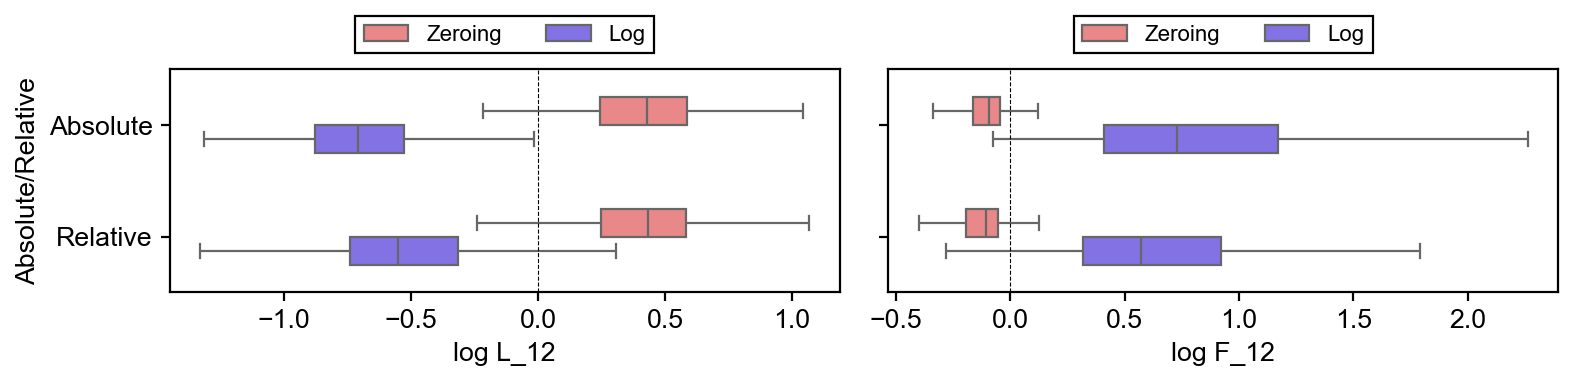

In [66]:
row = 1
col = 2
scale = 3
fig, axs = plt.subplots(row, col, figsize=(10, 5), sharey=True)
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
print(plot_df.shape)
box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Absolute/Relative',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=0.85,
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
print(plot_df.shape)
box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Absolute/Relative',
    hue='Mistake',
    ax=axs[1],
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=0.85,
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

for i in range(col):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
    axs[i].set_box_aspect(1/3)
    # axs[i].axis('off')
plt.tight_layout()

In [67]:
np.unique(plot_df['Physical quantity II'])

array(['Bioluminescence', 'Concentration', 'Constant', 'Count',
       'Fluorescence', 'Length', 'Mass', 'Others', 'Percentage',
       'Prediction metric', 'Ratio', 'Statistics', 'Temperature', 'Time'],
      dtype=object)

In [68]:
order = [
    'Percentage',
    'Ratio', 
    
    'Prediction metric', 
    'Statistics', 
    
    'Constant', 
    'Count',
    
    'Bioluminescence', 
    'Fluorescence', 
    
    'Concentration', 
    'Length', 
    'Mass', 
    'Temperature', 
    'Time',
    'Others', 
]

(1052, 19)
(1052, 19)


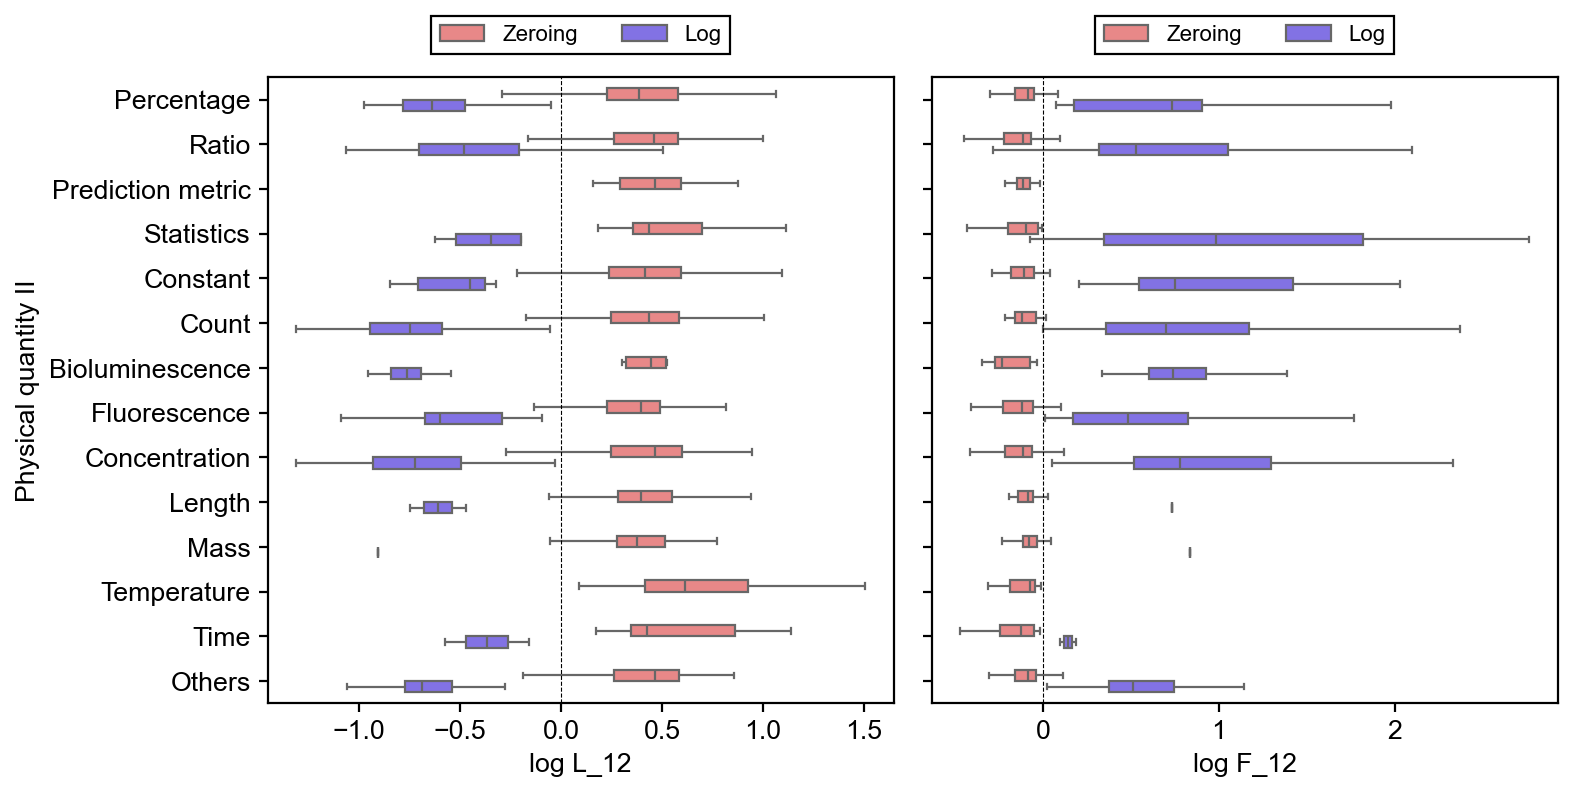

In [69]:
# plot n as one of the subplot
row = 1
col = 2
scale = 3
fig, axs = plt.subplots(row, col, figsize=(10, 5), sharey=True)
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Physical quantity II',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    legend=True,
    showfliers=False,
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=0.85,
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)


plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Physical quantity II',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    legend=True,
    showfliers=False,
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=0.85,
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

for i in range(col):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
    axs[i].set_box_aspect(1)
plt.tight_layout()

### Physical quantity I

(1091, 19)
(1091, 19)


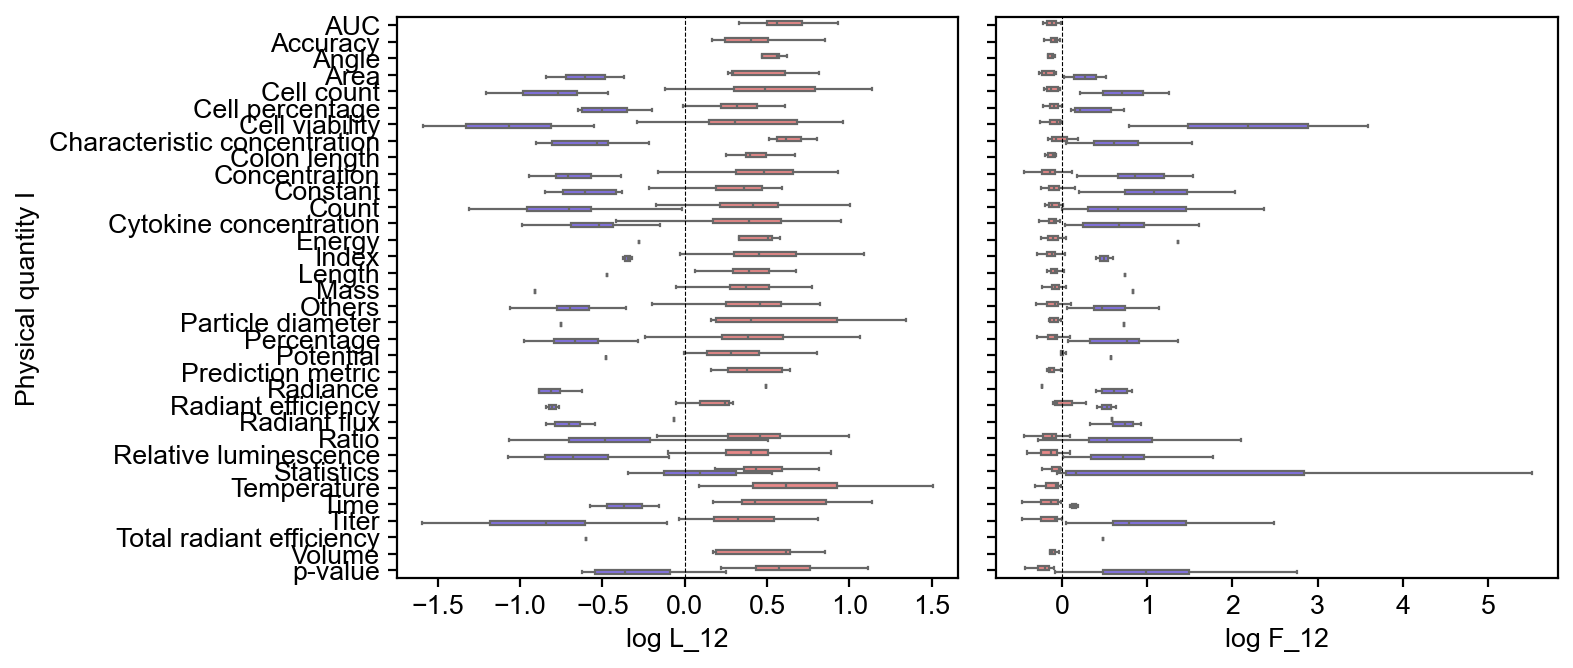

In [70]:
row = 1
col = 2
scale = 3
fig, axs = plt.subplots(row, col, figsize=(10, 5), sharey=True)
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median().reset_index()
print(plot_df.shape)
sns.boxplot(
    plot_df,
    x='log L_12',
    y='Physical quantity I',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    legend=False,
    showfliers=False,
    order=np.unique(plot_df['Physical quantity I']),
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=0.85,
)
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median().reset_index()
print(plot_df.shape)
sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Physical quantity I',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    legend=False,
    showfliers=False,
    order=np.unique(plot_df['Physical quantity I']),
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=0.85,
)
for i in range(col):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
    axs[i].set_box_aspect(1)
plt.tight_layout()

(1052, 19)
(1052, 19)


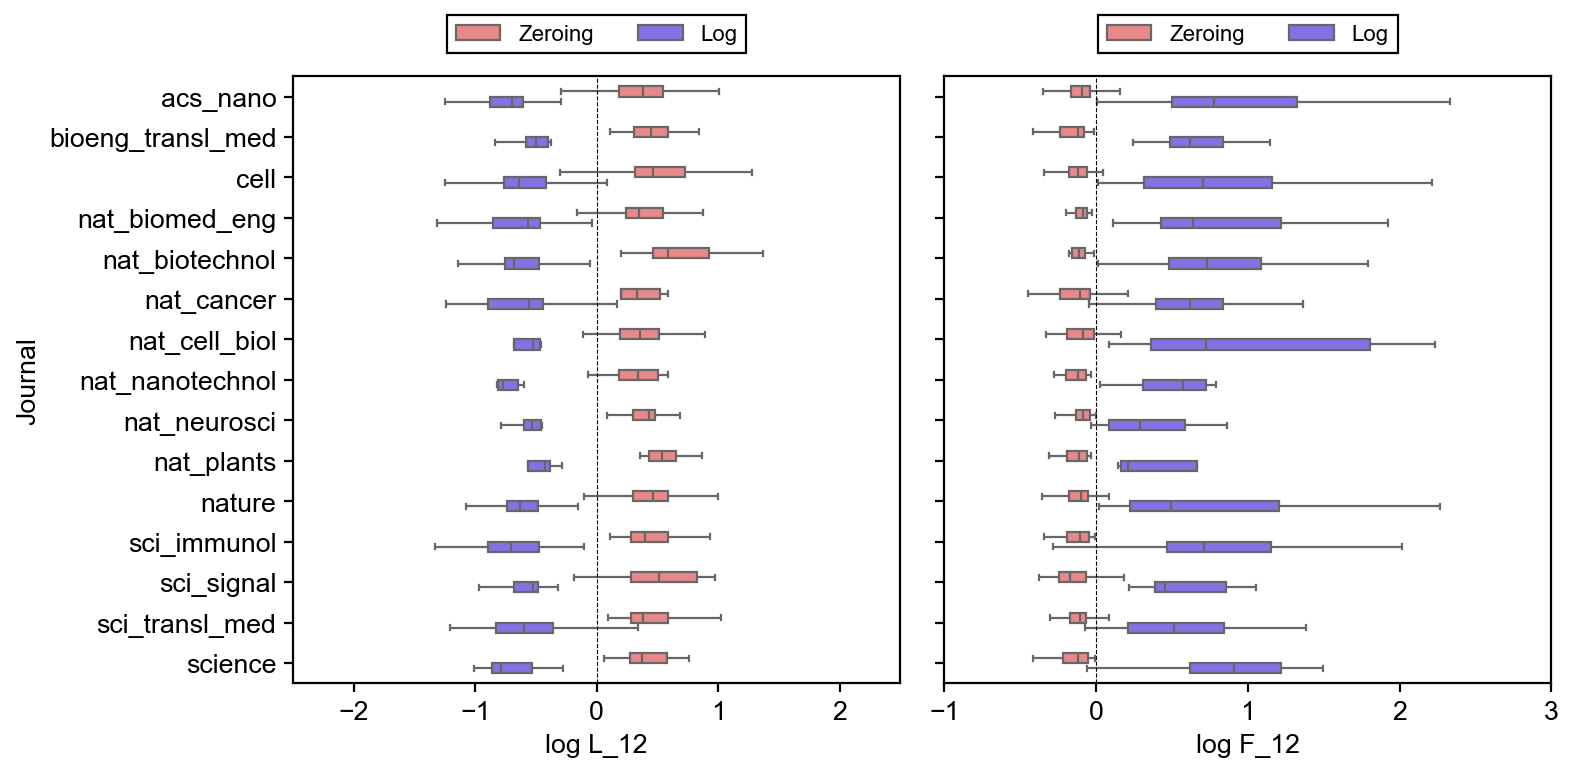

In [71]:
row = 1
col = 2
scale = 3
fig, axs = plt.subplots(row, col, figsize=(10, 5), sharey=True)
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Journal',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=0.85,
)
axs[0].set_xlim(-2.5, 2.5)

# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
print(plot_df.shape)
box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Journal',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=0.85,
)
axs[1].set_xlim(-1, 3)

# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

for i in range(col):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
    axs[i].set_box_aspect(1)
plt.tight_layout()

In [72]:
def filter_finite(df):
    df[df == np.inf] = np.nan
    df[df == -np.inf] = np.nan
    df = df.dropna(how='any')
    return df

n = 747 Zeroing
n = 323 Log
(1070, 18)
TtestResult(statistic=33.895601451048464, pvalue=3.6693220811320527e-153, df=746)
TtestResult(statistic=-30.367247493368716, pvalue=1.5900758044448778e-96, df=322)
SignificanceResult(statistic=395.92983425705745, pvalue=1.0590802777205598e-86)
SignificanceResult(statistic=665.0858143591614, pvalue=3.78835278995847e-145)
n = 744 Zeroing
n = 323 Log
(1067, 18)
TtestResult(statistic=-17.241815600849197, pvalue=2.7405750057851473e-56, df=743)
TtestResult(statistic=18.691282458419227, pvalue=2.587219243798362e-53, df=322)
SignificanceResult(statistic=12290.132412936075, pvalue=0.0)
SignificanceResult(statistic=2948.851276798101, pvalue=0.0)


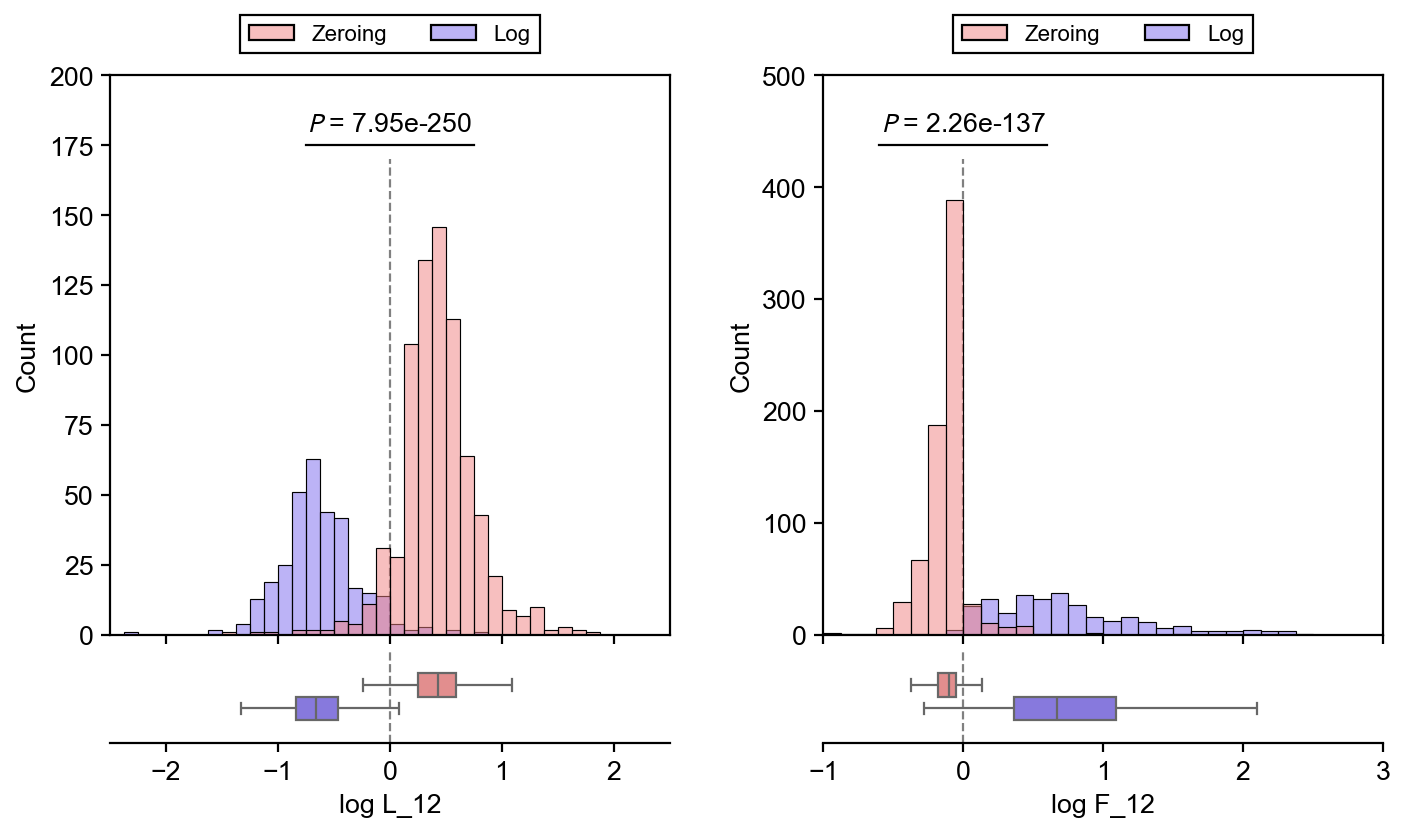

In [73]:
bins = np.arange(-2.5, 2.5 + 0.125, 0.125)

fig, axs = plt.subplots(2, 2, figsize=(9, 5), height_ratios=[6, 1])
ax_box_rel = axs[1, 0]
ax_hist_rel = axs[0, 0]
ax_box_abs = axs[1, 1]
ax_hist_abs = axs[0, 1]

## subplot 1
# eliminate bar-level bias by groupby graphs
plot_df = L_df.groupby(L_df.index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Physical quantity I']])
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
plot_df = filter_finite(plot_df)
plot_df = plot_df.reset_index()
print(f"n = {sum(plot_df['Mistake'] == 'zero')} Zeroing")
print(f"n = {sum(plot_df['Mistake'] == 'log')} Log")
print(plot_df.shape)

sns.boxplot(
    plot_df,
    x='log L_12',
    hue='Mistake', 
    ax=ax_box_rel,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
hist = sns.histplot(
    plot_df,
    x='log L_12', 
    hue='Mistake', 
    # kde=True,
    bins=bins,
    ax=ax_hist_rel,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_rel.set_xlim(-2.5, 2.5)
ax_hist_rel.set_xlim(-2.5, 2.5)
ax_hist_rel.set_ylim(0, 200)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label p-value
print(scipy.stats.ttest_1samp(plot_df.loc[plot_df['Mistake'] == 'zero', 'log L_12'].dropna(), 0))
print(scipy.stats.ttest_1samp(plot_df.loc[plot_df['Mistake'] == 'log', 'log L_12'].dropna(), 0))
print(scipy.stats.jarque_bera(plot_df.loc[plot_df['Mistake'] == 'zero', 'log L_12'].dropna()))
print(scipy.stats.jarque_bera(plot_df.loc[plot_df['Mistake'] == 'log', 'log L_12'].dropna()))
stat, pvalue = scipy.stats.ttest_ind(
    plot_df.loc[plot_df['Mistake'] == 'zero', 'log L_12'].dropna(),
    plot_df.loc[plot_df['Mistake'] == 'log', 'log L_12'].dropna(),
)
ax_hist_rel.text(
    0.5, 
    0.9, 
    '$\it{P}$ = ' + f'{pvalue:.2e}',
    ha='center',
    transform=ax_hist_rel.transAxes,
)
ax_hist_rel.axhline(
    0.875 * ax_hist_rel.get_ylim()[1],
    0.35, 
    0.65,
    color='k',
    lw=1,
)

## subplot 2
# eliminate bar-level bias by groupby graphs
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Physical quantity I']])  
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
plot_df = filter_finite(plot_df)
plot_df = plot_df.reset_index()
print(f"n = {sum(plot_df['Mistake'] == 'zero')} Zeroing")
print(f"n = {sum(plot_df['Mistake'] == 'log')} Log")
print(plot_df.shape)

sns.boxplot(
    plot_df,
    x='log F_12',
    hue='Mistake', 
    ax=ax_box_abs,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
hist = sns.histplot(
    plot_df,
    x='log F_12', 
    hue='Mistake', 
    # kde=True,
    bins=bins,
    ax=ax_hist_abs,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_abs.set_xlim(-1, 3)
ax_hist_abs.set_xlim(-1, 3)
ax_hist_abs.set_ylim(0, 500)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label p-value
print(scipy.stats.ttest_1samp(plot_df.loc[plot_df['Mistake'] == 'zero', 'log F_12'].dropna(), 0))
print(scipy.stats.ttest_1samp(plot_df.loc[plot_df['Mistake'] == 'log', 'log F_12'].dropna(), 0))
print(scipy.stats.jarque_bera(plot_df.loc[plot_df['Mistake'] == 'zero', 'log F_12'].dropna()))
print(scipy.stats.jarque_bera(plot_df.loc[plot_df['Mistake'] == 'log', 'log F_12'].dropna()))
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[plot_df['Mistake'] == 'zero', 'log F_12'].dropna(),
    plot_df.loc[plot_df['Mistake'] == 'log', 'log F_12'].dropna(),
)
ax_hist_abs.text(
    0.25, 
    0.90, 
    '$\it{P}$ = ' + f'{pvalue:.2e}',
    ha='center',
    transform=ax_hist_abs.transAxes,
)
ax_hist_abs.axhline(
    0.875 * ax_hist_abs.get_ylim()[1],
    0.10, 
    0.4,
    color='k',
    lw=1,
)
ax_hist_abs.get_ylim()
# common labels by row and col
for i in range(2):
    axs[0, i].set_box_aspect(1)
    axs[0, i].set_xlabel('')
    axs[0, i].set_xticklabels('')
    axs[0, i].axvline(0, 0, 0.85, color='gray', lw=1, ls='--', zorder=0)
    
    axs[1, i].set_box_aspect(1/6)
    axs[1, i].axis()
    axs[1, i].spines['left'].set_linewidth(0)
    axs[1, i].spines['right'].set_linewidth(0)
    axs[1, i].spines['top'].set_linewidth(0)
    axs[1, i].tick_params(
        axis='y',
        which='both',
        left=False,
    )
    axs[1, i].axvline(0, 0, 1, color='gray', lw=1, ls='--', zorder=0)

plt.tight_layout(pad=0)

!!! n subject to change, preliminary !!!

Distribution of log-transformed lie factor of (a) relative change and (b) fold change for quantity-normalized zeroing (n = 439) and log (n = 318) mistakes. 

## Graph-level metric

In [74]:
grouped_alpha = (bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0))
grouped_alpha_inverse = (1 / bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0))

In [75]:
cv_df = grouped_alpha.std() / grouped_alpha.mean()
cv_df = cv_df.to_frame()
cv_df.columns = ['CV alpha_i']
cv_df['log CV alpha_i'] = np.log10(cv_df['CV alpha_i'])

cv_df['CV alpha_i inverse'] = grouped_alpha_inverse.std() / grouped_alpha_inverse.mean()
cv_df['log CV alpha_i inverse'] = np.log10(cv_df['CV alpha_i inverse'])

cv_df['Mean CV alpha_i'] = (cv_df['CV alpha_i'] + cv_df['CV alpha_i inverse']) / 2
cv_df['log Mean CV alpha_i'] = np.log10(cv_df['Mean CV alpha_i'])

cv_df['IQR over median alpha_i'] = (grouped_alpha.quantile(0.75) - grouped_alpha.quantile(0.25)) / grouped_alpha.median()
cv_df['log IQR over median alpha_i'] = np.log10(cv_df['IQR over median alpha_i'])

cv_df['IQR over median alpha_i inverse'] = (grouped_alpha_inverse.quantile(0.75) - grouped_alpha_inverse.quantile(0.25)) / grouped_alpha_inverse.median()
cv_df['log IQR over median alpha_i inverse'] = np.log10(cv_df['IQR over median alpha_i inverse'])

cv_df['Mean IQR over median alpha_i'] = (cv_df['IQR over median alpha_i'] + cv_df['IQR over median alpha_i inverse']) / 2
cv_df['log Mean IQR over median alpha_i'] = np.log10(cv_df['Mean IQR over median alpha_i'])

cv_df['MAD alpha_i'] = grouped_alpha.agg(lambda pop: np.median(np.abs(pop - np.median(pop))))
cv_df['log MAD alpha_i'] = np.log10(cv_df['MAD alpha_i'])

cv_df['MAD alpha_i inverse'] = grouped_alpha_inverse.agg(lambda pop: np.median(np.abs(pop - np.median(pop))))
cv_df['log MAD alpha_i inverse'] = np.log10(cv_df['MAD alpha_i inverse'])

cv_df['Mean MAD alpha_i'] = (cv_df['MAD alpha_i'] + cv_df['MAD alpha_i inverse']) / 2
cv_df['log Mean MAD alpha_i'] = np.log10(cv_df['Mean MAD alpha_i'])


cv_df['MAD alpha_i over median'] = grouped_alpha.agg(lambda pop: np.median(np.abs(pop - np.median(pop)))) / grouped_alpha.median()
cv_df['log MAD alpha_i over median'] = np.log10(cv_df['MAD alpha_i over median'])

cv_df['MAD alpha_i over median inverse'] = grouped_alpha_inverse.agg(lambda pop: np.median(np.abs(pop - np.median(pop)))) / grouped_alpha_inverse.median()
cv_df['log MAD alpha_i over median inverse'] = np.log10(cv_df['MAD alpha_i over median inverse'])

cv_df['Mean MAD alpha_i over median'] = (cv_df['MAD alpha_i over median'] + cv_df['MAD alpha_i over median inverse']) / 2
cv_df['log Mean MAD alpha_i over median'] = np.log10(cv_df['Mean MAD alpha_i over median'])

# cv_df = pd.DataFrame(np.abs(np.log10(bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0)).std() / np.log10(bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0)).mean()))

# tag meta data
cv_df = cv_df.join(bar_annot_df['Mistake'].to_frame())
cv_df

,CV alpha_i,log CV alpha_i,CV alpha_i inverse,log CV alpha_i inverse,Mean CV alpha_i,log Mean CV alpha_i,IQR over median alpha_i,log IQR over median alpha_i,IQR over median alpha_i inverse,log IQR over median alpha_i inverse,...,log MAD alpha_i inverse,Mean MAD alpha_i,log Mean MAD alpha_i,MAD alpha_i over median,log MAD alpha_i over median,MAD alpha_i over median inverse,log MAD alpha_i over median inverse,Mean MAD alpha_i over median,log Mean MAD alpha_i over median,Mistake
10.1002:btm2.10487_log_fig1,0.845068,-0.073108,1.132176,0.053914,0.988622,-0.004970,1.190664,0.075789,1.730117,0.238076,...,0.418227,1.392038,0.143651,0.634760,-0.197390,0.545305,-0.263361,0.590032,-0.229124,log
10.1002:btm2.10487_log_fig2,1.048477,0.020559,1.584681,0.199942,1.316579,0.119447,1.720471,0.235647,3.872882,0.588034,...,0.941820,4.446381,0.648007,0.833423,-0.079135,0.762112,-0.117981,0.797767,-0.098124,log
10.1002:btm2.10499_zero_fig1,0.457477,-0.339630,0.572072,-0.242549,0.514775,-0.288383,0.760722,-0.118774,0.869892,-0.060535,...,1.368126,11.673848,1.067214,0.404966,-0.392581,0.355302,-0.449403,0.380134,-0.420063,zero
10.1002:btm2.10499_zero_fig2,0.139314,-0.856007,0.151607,-0.819280,0.145460,-0.837255,0.183955,-0.735289,0.173445,-0.760838,...,0.527409,1.685190,0.226649,0.087628,-1.057357,0.080568,-1.093837,0.084098,-1.075214,zero
10.1002:btm2.10499_zero_fig3,0.139831,-0.854397,0.136558,-0.864683,0.138195,-0.859509,0.205211,-0.687798,0.185312,-0.732097,...,0.446887,1.400057,0.146146,0.074777,-1.126234,0.069574,-1.157552,0.072175,-1.141611,zero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1126:scitranslmed.adi7244_zero_fig1,0.198204,-0.702888,0.198204,-0.702888,0.198204,-0.702888,0.140151,-0.853403,0.140151,-0.853403,...,1.061309,5.758973,0.760345,0.140151,-0.853403,0.140151,-0.853403,0.140151,-0.853403,zero
10.1126:scitranslmed.adi7244_zero_fig2,0.701399,-0.154035,0.701399,-0.154035,0.701399,-0.154035,0.495964,-0.304550,0.495964,-0.304550,...,2.126860,66.963535,1.825838,0.495964,-0.304550,0.495964,-0.304550,0.495964,-0.304550,zero
10.1126:scitranslmed.adi7244_zero_fig3,0.468870,-0.328947,0.468870,-0.328947,0.468870,-0.328947,0.331541,-0.479462,0.331541,-0.479462,...,1.752099,28.254394,1.451086,0.331541,-0.479462,0.331541,-0.479462,0.331541,-0.479462,zero
10.1126:scitranslmed.adi9867_log_fig1,0.242860,-0.614644,0.286868,-0.542318,0.264864,-0.576977,0.223449,-0.650822,0.264978,-0.576790,...,1.103627,6.347947,0.802633,0.122944,-0.910291,0.109537,-0.960440,0.116241,-0.934642,log


In [76]:
cv_df[(cv_df['log CV alpha_i'] < 0) & (cv_df['Mistake'] == 'log')]

,CV alpha_i,log CV alpha_i,CV alpha_i inverse,log CV alpha_i inverse,Mean CV alpha_i,log Mean CV alpha_i,IQR over median alpha_i,log IQR over median alpha_i,IQR over median alpha_i inverse,log IQR over median alpha_i inverse,...,log MAD alpha_i inverse,Mean MAD alpha_i,log Mean MAD alpha_i,MAD alpha_i over median,log MAD alpha_i over median,MAD alpha_i over median inverse,log MAD alpha_i over median inverse,Mean MAD alpha_i over median,log Mean MAD alpha_i over median,Mistake
10.1002:btm2.10487_log_fig1,0.845068,-0.073108,1.132176,0.053914,0.988622,-0.004970,1.190664,0.075789,1.730117,0.238076,...,0.418227,1.392038e+00,0.143651,0.634760,-0.197390,0.545305,-0.263361,0.590032,-0.229124,log
10.1002:btm2.10514_log_fig1,0.603059,-0.219640,0.773163,-0.111729,0.688111,-0.162342,0.745028,-0.127827,0.760501,-0.118900,...,4.493158,1.556425e+04,4.192128,0.397693,-0.400452,0.408008,-0.389331,0.402851,-0.394856,log
10.1002:btm2.10594_log_fig2,0.809061,-0.092019,0.841028,-0.075189,0.825045,-0.083522,1.315691,0.119154,1.970728,0.294627,...,9.184547,7.647458e+08,8.883517,0.677248,-0.169252,0.581691,-0.235308,0.629469,-0.201025,log
10.1002:btm2.10594_log_fig3,0.639497,-0.194162,0.682930,-0.165624,0.661213,-0.179659,0.676492,-0.169737,0.880548,-0.055247,...,8.993496,4.925678e+08,8.692466,0.420588,-0.376143,0.434771,-0.361740,0.427679,-0.368882,log
10.1016:j.cell.2022.11.026_log_fig3,0.955760,-0.019651,1.505879,0.177790,1.230819,0.090194,2.073266,0.316655,271.448135,2.433687,...,-4.002942,3.546520e+03,3.549802,0.997156,-0.001237,0.633826,-0.198030,0.815491,-0.088581,log
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1126:scitranslmed.adh4529_log_fig1,0.904090,-0.043788,1.513834,0.180078,1.208962,0.082413,2.775965,0.443414,1.377527,0.139100,...,2.030590,5.365166e+01,1.729583,0.802655,-0.095471,0.738118,-0.131874,0.770386,-0.113291,log
10.1126:scitranslmed.adh4529_log_fig2,0.354307,-0.450620,0.451029,-0.345796,0.402668,-0.395053,0.620154,-0.207501,0.819240,-0.086589,...,-0.258717,3.291582e-01,-0.482595,0.267676,-0.572390,0.220630,-0.656336,0.244153,-0.612338,log
10.1126:scitranslmed.adh4529_log_fig3,0.414744,-0.382220,0.759625,-0.119401,0.587185,-0.231225,0.529056,-0.276498,0.666873,-0.175957,...,-0.232585,3.455375e-01,-0.461505,0.262419,-0.581005,0.235832,-0.627397,0.249126,-0.603582,log
10.1126:scitranslmed.adi9867_log_fig1,0.242860,-0.614644,0.286868,-0.542318,0.264864,-0.576977,0.223449,-0.650822,0.264978,-0.576790,...,1.103627,6.347947e+00,0.802633,0.122944,-0.910291,0.109537,-0.960440,0.116241,-0.934642,log


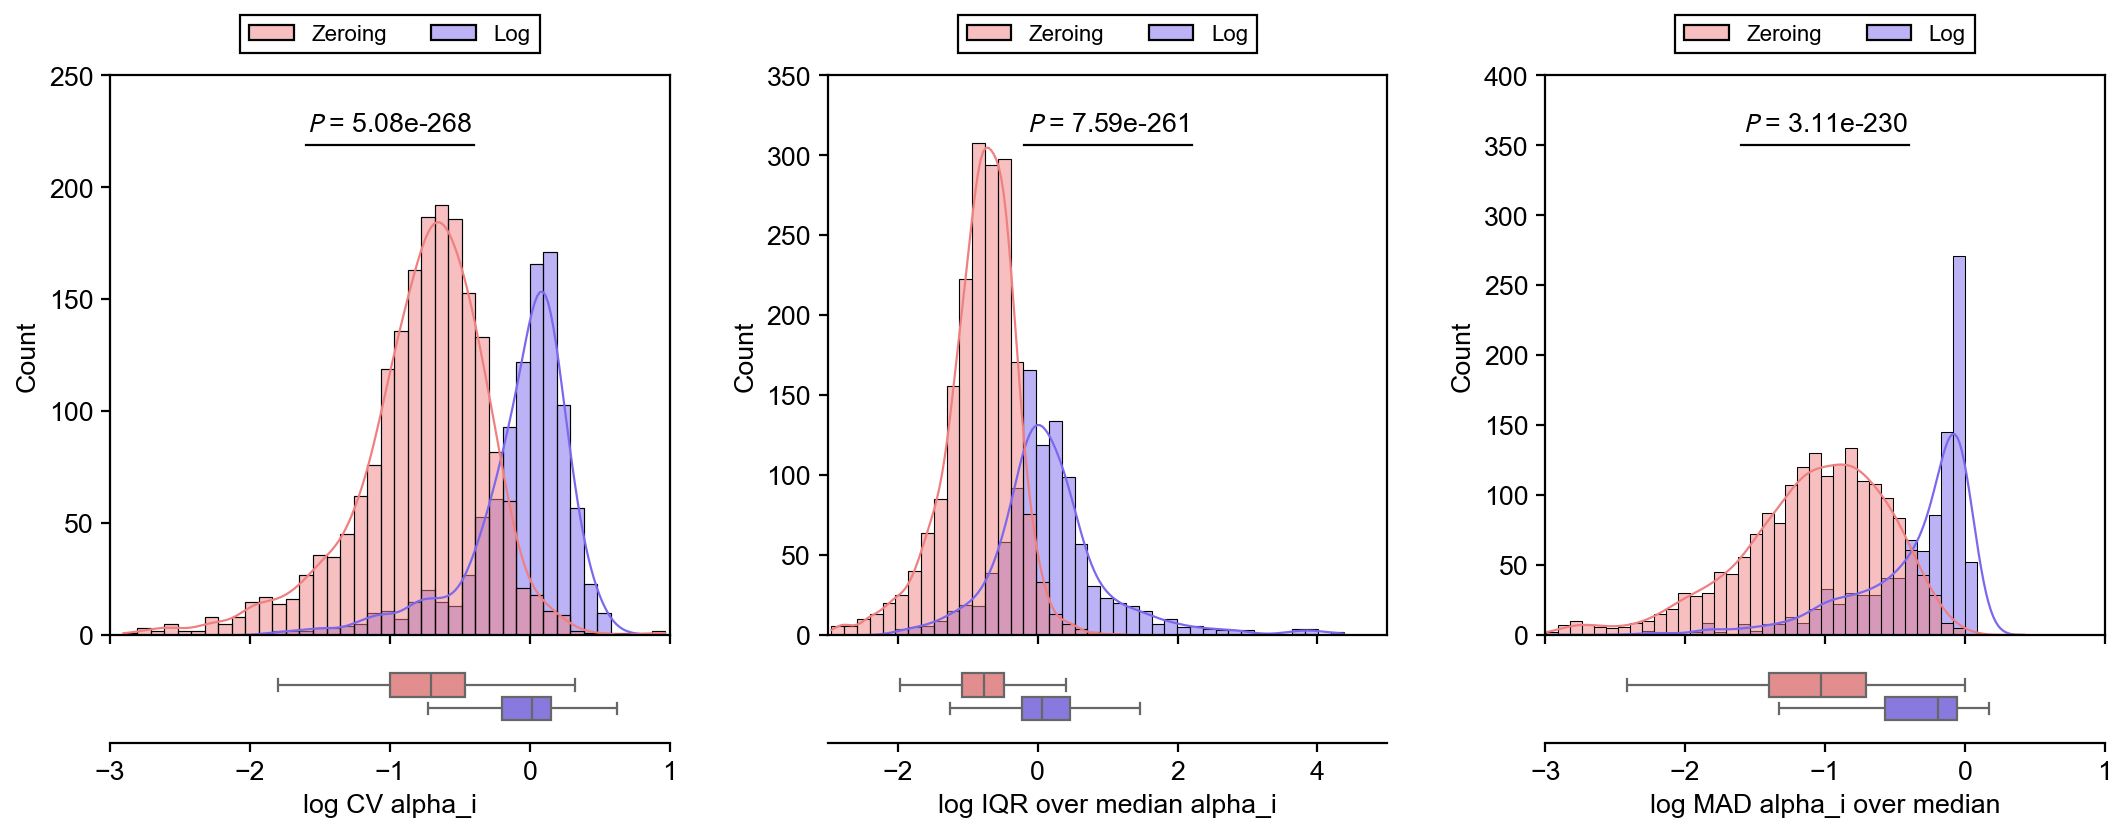

In [77]:
property_list = [
    'CV alpha_i',
    # 'CV alpha_i inverse',
    # 'Mean CV alpha_i',
    'IQR over median alpha_i',
    # 'IQR over median alpha_i inverse',
    # 'Mean IQR over median alpha_i',
    # 'MAD alpha_i',
    'MAD alpha_i over median',
    # 'MAD alpha_i inverse',
    # 'Mean MAD alpha_i',
]
row = 2
col = len(property_list)
scale = 3
fig, axs = plt.subplots(row, col, figsize=(13.5, 5), height_ratios=[6, 1], sharex='col')

axs[0, 0].set_ylim(0, 250)
axs[0, 1].set_ylim(0, 350)
axs[0, 2].set_ylim(0, 400)

axs[0, 0].set_xlim(-3, 1)
axs[0, 1].set_xlim(-3, 5)
axs[0, 2].set_xlim(-3, 1)

for col_i in range(col):
    xmin, xmax = axs[0, col_i].get_xlim()
    plot_df = cv_df[cv_df['CV alpha_i'] > 0]
    plot_df = plot_df.dropna()
    ## first row
    hist = sns.histplot(
        plot_df[
            (plot_df[f'log {property_list[col_i]}'] >= xmin)
            & (plot_df[f'log {property_list[col_i]}'] <= xmax)
        ],
        x=f'log {property_list[col_i]}',
        hue='Mistake',
        bins=40,
        kde=True,
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        ax=axs[0, col_i],
    )
    # configure legend
    sns.move_legend(
        hist, 
        loc='lower center', 
        **dict(
            bbox_to_anchor=(0.5, 1.02),
            title='',
            labels=[ZERO_LABEL, LOG_LABEL],
            ncol=2,
        )
    )

    # second row
    box = sns.boxplot(
        plot_df,
        x=f'log {property_list[col_i]}',
        hue='Mistake',
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        width=0.5,
        legend=False,
        showfliers=False,
        ax=axs[1, col_i],
    )
    
    # label p-value
    stat, pvalue = scipy.stats.mannwhitneyu(
        plot_df.loc[plot_df['Mistake'] == 'zero', property_list[col_i]],
        plot_df.loc[plot_df['Mistake'] == 'log', property_list[col_i]],
    )
    axs[0, col_i].text(
        0.5, 
        0.90, 
        '$\it{P}$ = ' + f'{pvalue:.2e}',
        ha='center',
        transform=axs[0, col_i].transAxes,
    )
    axs[0, col_i].axhline(
        0.875 * axs[0, col_i].get_ylim()[1],
        0.35, 
        0.65,
        color='k',
        lw=1,
    )

for col_i in range(col):
    for row_i in range(row):
        axs[0, col_i].set_box_aspect(1)
        # axs[0, col_i].axvline(0, 0, 1, color='gray', lw=1, ls='--')
        axs[1, col_i].set_box_aspect(1/6)
        # axs[1, col_i].axvline(0, 0, 1, color='gray', lw=1, ls='--')
        axs[1, col_i].spines['left'].set_linewidth(0)
        axs[1, col_i].spines['right'].set_linewidth(0)
        axs[1, col_i].spines['top'].set_linewidth(0)
        axs[1, col_i].tick_params(
            axis='y',
            which='both',
            left=False,
        )
plt.tight_layout(pad=0)

In [78]:
plot_df = cv_df[cv_df['CV alpha_i'] > 0]
plot_df = plot_df.dropna()

In [79]:
# label p-value
property = 'log MAD alpha_i'
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[(plot_df['Mistake'] == 'zero'), property],
    plot_df.loc[(plot_df['Mistake'] == 'log'), property],
)
pvalue

6.383340529283934e-23